In [1473]:
import unicodedata
import re
import trnlp
from zemberek.lm import SmoothLM
from zemberek.morphology import TurkishMorphology
from zemberek.normalization import TurkishSpellChecker
from zemberek.tokenization import TurkishTokenizer
import jpype
import jpype.imports
from jpype.types import *
from multiprocessing import Pool, cpu_count
import multiprocessing as mp
from fuzzywuzzy import process
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
#%pip install missingno
#import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
#from scipy.stats import norm
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import scipy
#import scipy.stats as stats
#from scipy.stats import skew,boxcox_normmax, zscore
#from scipy.special import boxcox1p
#from scipy.stats import boxcox
#from scipy.stats import boxcox_normmax

In [1474]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [1475]:
#######################################################
# For Dataset Loading
######################################################
def load_train():
    data = pd.read_csv("../research/datasets/train.csv")
    return data

def load_test():
    data = pd.read_csv("../research/datasets/test.csv")
    return data

def concat_df_on_y_axis(df_1, df_2):
    return pd.concat([df_1, df_2])

def concat_df_on_x_axis(df_1, df_2):
    return pd.concat([df_1, df_2], axis = 1)

def grab_col_names(dataframe, cat_th=15, car_th=30):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


######################################################
# For Outliers
######################################################
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

######################################################
# For Missing Values
######################################################
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return missing_df, na_columns
    
    return missing_df

def quick_missing_imp_groupped(data, cat_cols, num_cols, missing_columns_df, num_method = 'median', groupby = 'Neighborhood', target = 'SalePrice'):
    missing_columns = missing_columns_df.T.columns
    missing_columns = [col for col in missing_columns if col not in target]
    missing_cat_cols = [col for col in missing_columns if col not in num_cols]
    missing_num_cols = [col for col in missing_columns if col not in cat_cols]

    print("# BEFORE")
    print(missing_columns_df)  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    data[missing_cat_cols] = data.groupby(groupby)[missing_cat_cols].transform(lambda x:x.fillna(x.mode()[0]))

    if num_method == "mean":
        data[missing_num_cols] = data.groupby(groupby)[missing_num_cols].transform(lambda x: x.fillna(x.mean()))
        
    elif num_method == "median":
        data[missing_num_cols] = data.groupby(groupby)[missing_num_cols].transform(lambda x: x.fillna(x.median()))
    
    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[missing_columns].isnull().sum(), "\n\n")

    return data


######################################################
# For Encoders
######################################################
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def one_hot_encoder_na_dummy(dataframe, categorical_cols, drop_first=True, dummy_na=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dummy_na = dummy_na)
    return dataframe

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_analyser(dataframe, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe)}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

######################################################
# For EDA
######################################################
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        #import seaborn as sns
        #import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    #print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

In [1476]:
df_train = load_train()
df_test = load_test()

C:\Users\BORA\AppData\Local\Temp\ipykernel_18312\441925919.py:5: DtypeWarning: Columns (13,15,19,30,32,37,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../research/datasets/train.csv")


In [1477]:
df_train = df_train.dropna(subset=['Degerlendirme Puani'])

In [1478]:
df = concat_df_on_y_axis(df_train, df_test)

In [1479]:
df_copy = df.copy()
check_df(df_copy)

##################### Shape #####################
(76173, 44)
##################### Types #####################
Basvuru Yili                                                   int64
Degerlendirme Puani                                          float64
Cinsiyet                                                      object
Dogum Tarihi                                                  object
Dogum Yeri                                                    object
Ikametgah Sehri                                               object
Universite Adi                                                object
Universite Turu                                               object
Burslu ise Burs Yuzdesi                                      float64
Burs Aliyor mu?                                               object
Bölüm                                                         object
Universite Kacinci Sinif                                      object
Universite Not Ortalamasi                                   

In [1480]:
# Degerlendirme Puani haricindeki sütunları seçelim
columns_to_fill = df_copy.columns.difference(['Degerlendirme Puani'])

# Seçilen sütunlarda 'nan' değerlerini np.nan ile değiştirelim
df_copy[columns_to_fill] = df_copy[columns_to_fill].replace('nan', np.nan)

# Seçilen sütunlardaki NaN değerlerini 0 ile dolduralım
df_copy[columns_to_fill] = df_copy[columns_to_fill].fillna(0)

In [1481]:
df_copy.drop(['id'], axis = 1, inplace = True)

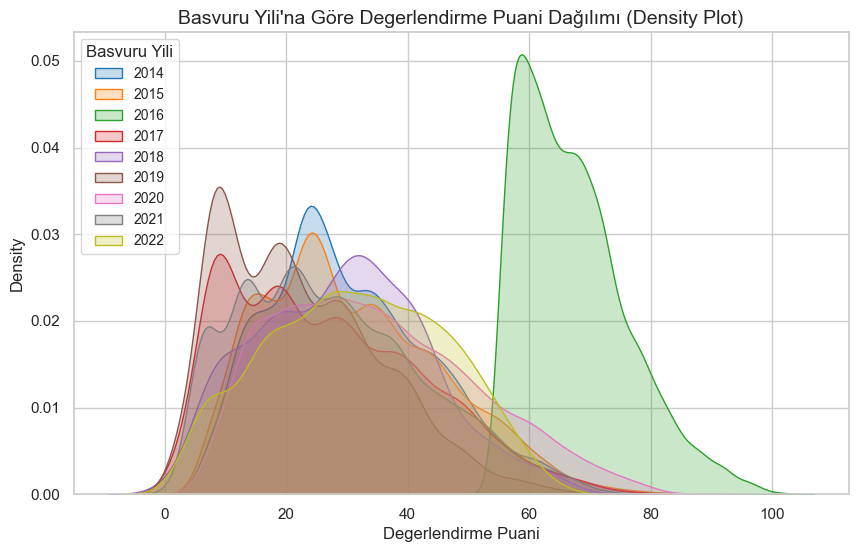

In [1482]:
sns.set(style="whitegrid")

# Farklı renkler için palet
colors = sns.color_palette("tab10", n_colors=9)

# Grafik boyutunu ayarlama
plt.figure(figsize=(10, 6))

# Her yılın değerlendirme puanına göre density plot çizme
for i, year in enumerate(range(2014, 2023)):
    subset = df[df['Basvuru Yili'] == year]
    sns.kdeplot(subset['Degerlendirme Puani'], color=colors[i], label=str(year), fill=True)

# Başlık, etiketler ve gösterge
plt.title("Basvuru Yili'na Göre Degerlendirme Puani Dağılımı (Density Plot)", fontsize=14)
plt.xlabel("Degerlendirme Puani", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Basvuru Yili", loc="upper left", fontsize=10)

# Grafiği göster
plt.show()

In [1483]:
df_copy = df_copy[df_copy['Basvuru Yili'] != 2016]

In [1484]:
cat_cols_eda, num_cols_eda, cat_but_car_eda = grab_col_names(df_train)

Observations: 65124
Variables: 44
cat_cols: 25
num_cols: 3
cat_but_car: 16
num_but_cat: 1


In [1485]:
cat_cols_test, num_cols_test, cat_but_car_test = grab_col_names(df_test)

Observations: 11049
Variables: 43
cat_cols: 32
num_cols: 1
cat_but_car: 10
num_but_cat: 10


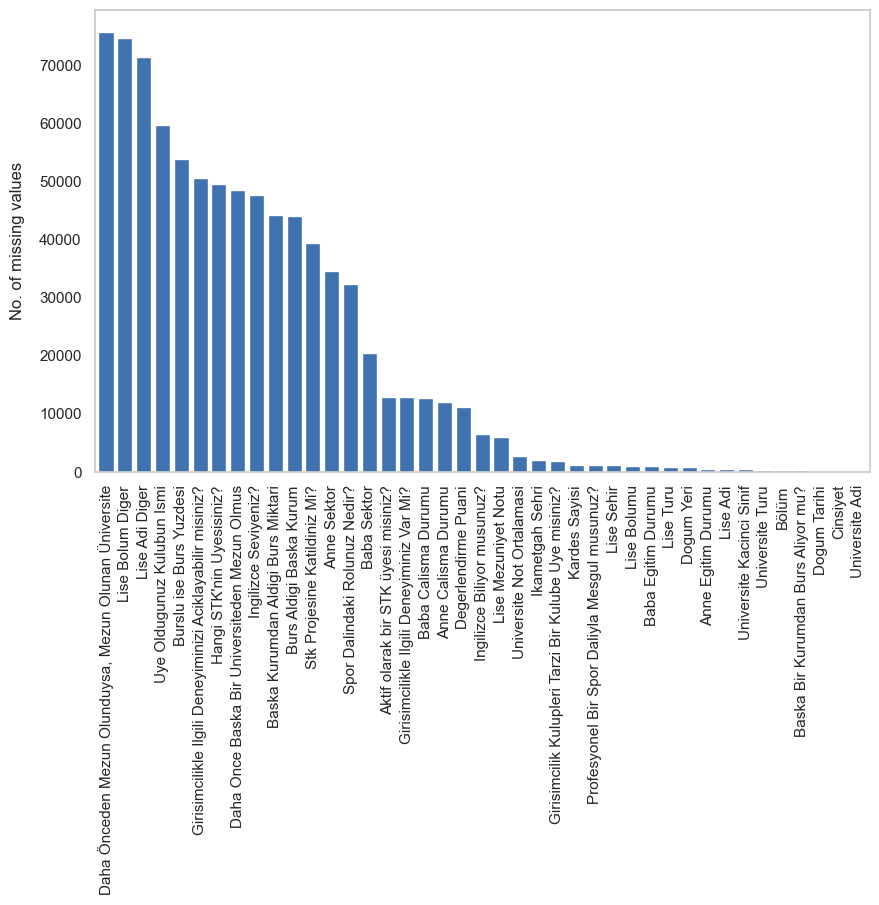

In [1486]:
nans = df.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.bar(nans.index, nans.values, zorder=2, color="#3f72af")
ax.set_ylabel("No. of missing values", labelpad=10)
ax.set_xlim(-0.6, len(nans) - 0.4)
ax.xaxis.set_tick_params(rotation=90)
plt.show()

                       Cinsiyet  Ratio
Cinsiyet                              
Kadın                     32076 49.254
Erkek                     22752 34.936
ERKEK                     10012 15.374
Belirtmek istemiyorum       115  0.177


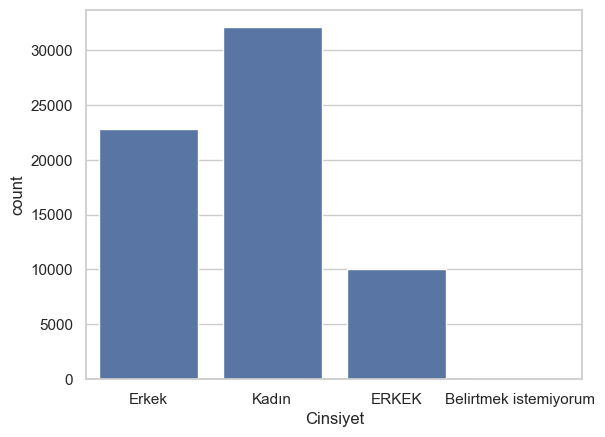

                 Universite Turu  Ratio
Universite Turu                        
Devlet                     37884 58.172
DEVLET                     15377 23.612
Özel                        8336 12.800
ÖZEL                        3272  5.024


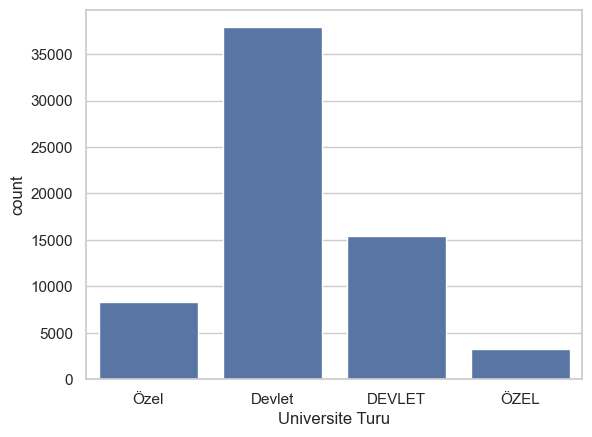

                 Burs Aliyor mu?  Ratio
Burs Aliyor mu?                        
Hayır                      51977 79.812
Evet                        9289 14.264
EVET                        3475  5.336
hayır                        272  0.418
evet                         111  0.170


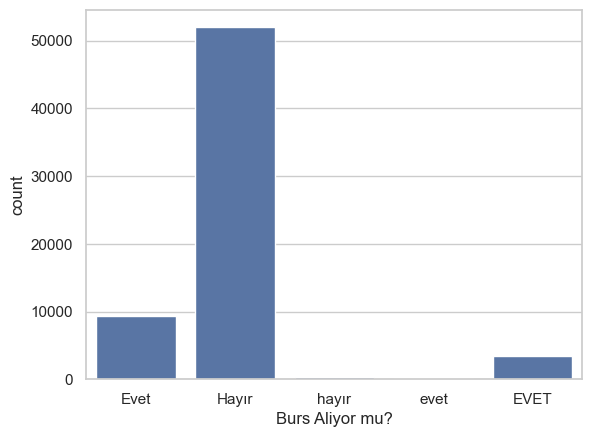

                          Universite Kacinci Sinif  Ratio
Universite Kacinci Sinif                                 
2                                            21773 33.433
3                                            16956 26.036
4                                            13112 20.134
1                                            10260 15.755
Hazırlık                                      1275  1.958
5                                              961  1.476
Mezun                                          178  0.273
6                                              177  0.272
hazırlık                                        33  0.051
Yüksek Lisans                                   15  0.023
Tez                                              7  0.011
0                                                3  0.005


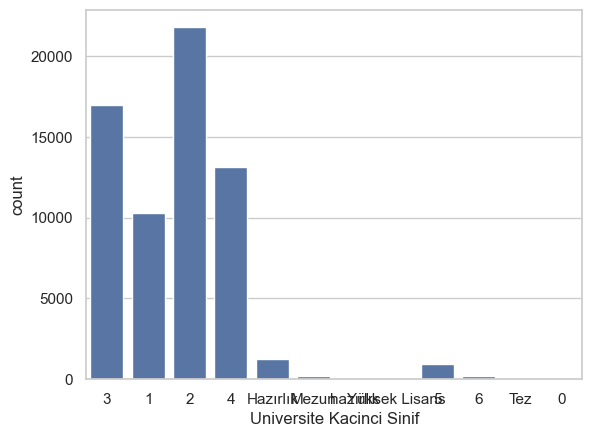

                           Universite Not Ortalamasi  Ratio
Universite Not Ortalamasi                                  
3.00-2.50                                      10758 16.519
2.50 ve altı                                   10554 16.206
3.00 - 3.50                                     7913 12.151
3.50-3                                          6179  9.488
2.50 - 3.00                                     5782  8.878
3.50 - 4.00                                     4462  6.852
2.00 - 2.50                                     2519  3.868
2.50 - 2.99                                     2451  3.764
ORTALAMA BULUNMUYOR                             2399  3.684
3.00 - 3.49                                     2382  3.658
2.50 -3.00                                      1734  2.663
3.00 - 4.00                                     1411  2.167
1.80 - 2.49                                     1166  1.790
Hazırlığım                                       668  1.026
Not ortalaması yok                      

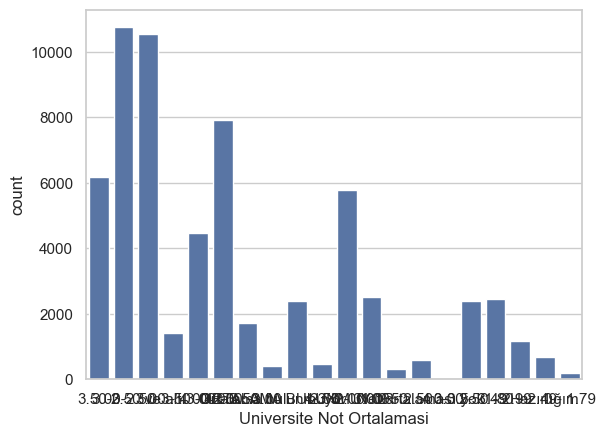

                                               Daha Once Baska Bir Universiteden Mezun Olmus  Ratio
Daha Once Baska Bir Universiteden Mezun Olmus                                                      
Hayır                                                                                  26624 40.882
Evet                                                                                    1156  1.775


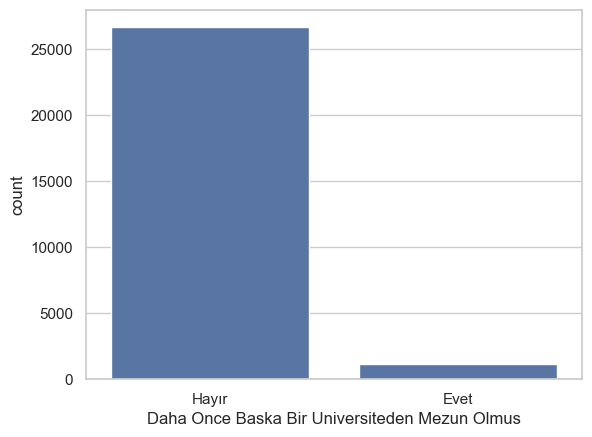

                   Lise Turu  Ratio
Lise Turu                          
Anadolu Lisesi         13367 20.525
Diğer                  13184 20.244
Anadolu lisesi          7002 10.752
Devlet                  6203  9.525
Özel                    4746  7.288
Düz lise                4179  6.417
Meslek lisesi           3666  5.629
Düz Lise                2789  4.283
Meslek                  2454  3.768
Fen Lisesi              2159  3.315
Özel Lisesi             1474  2.263
İmam Hatip Lisesi       1158  1.778
Fen lisesi               660  1.013
Özel lisesi              489  0.751
Meslek Lisesi            415  0.637
Özel Lise                332  0.510


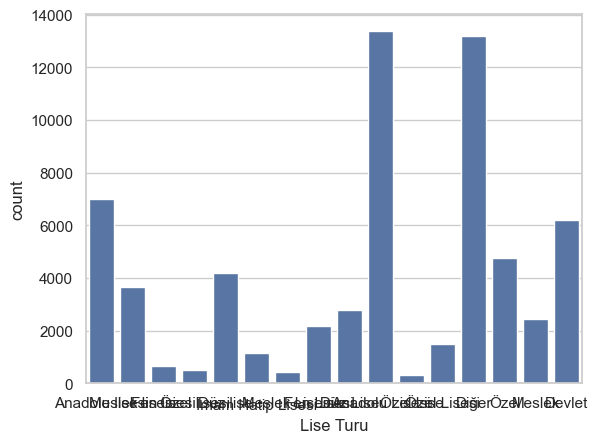

                     Lise Mezuniyet Notu  Ratio
Lise Mezuniyet Notu                            
75 - 100                           22432 34.445
84-70                               9141 14.036
100-85                              6967 10.698
4.00-3.50                           3689  5.665
50 - 75                             3115  4.783
3.00 - 4.00                         3101  4.762
3.50-3.00                           2759  4.237
3.50-3                              2330  3.578
69-55                               2162  3.320
3.00-2.50                           2153  3.306
50 - 74                             1007  1.546
2.50 ve altı                         226  0.347
54-45                                 88  0.135
25 - 50                               14  0.021
Not ortalaması yok                    11  0.017
44-0                                   6  0.009
0 - 25                                 3  0.005
25 - 49                                2  0.003
0 - 24                                 1

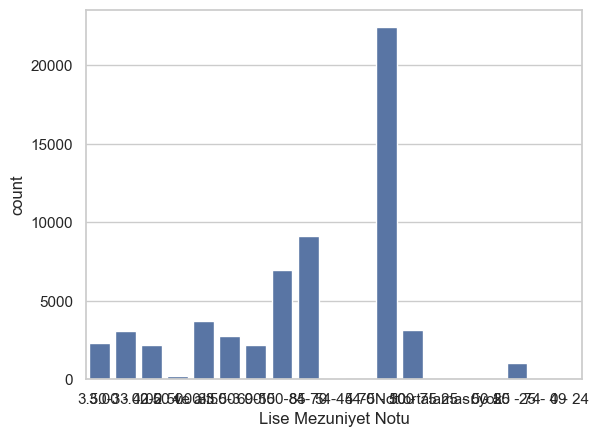

                                    Baska Bir Kurumdan Burs Aliyor mu?  Ratio
Baska Bir Kurumdan Burs Aliyor mu?                                           
Hayır                                                            48513 74.493
Evet                                                             16380 25.152


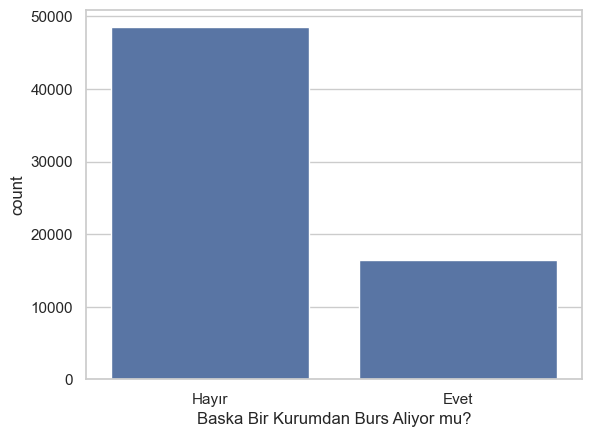

                         Anne Egitim Durumu  Ratio
Anne Egitim Durumu                                
İlkokul                               10350 15.893
Lise                                   8467 13.001
İlkokul Mezunu                         8030 12.330
İLKOKUL MEZUNU                         7770 11.931
Üniversite                             5502  8.448
Eğitimi yok                            3605  5.536
LİSE                                   3582  5.500
Ortaokul                               3126  4.800
EĞİTİM YOK                             2600  3.992
ÜNİVERSİTE                             2435  3.739
Eğitim Yok                             2146  3.295
Ortaokul Mezunu                        2119  3.254
ORTAOKUL MEZUNU                        1788  2.746
Lise Mezunu                            1346  2.067
Üniversite Mezunu                      1075  1.651
Yüksek Lisans                           274  0.421
YÜKSEK LİSANS                           153  0.235
Yüksek Lisans / Doktora        

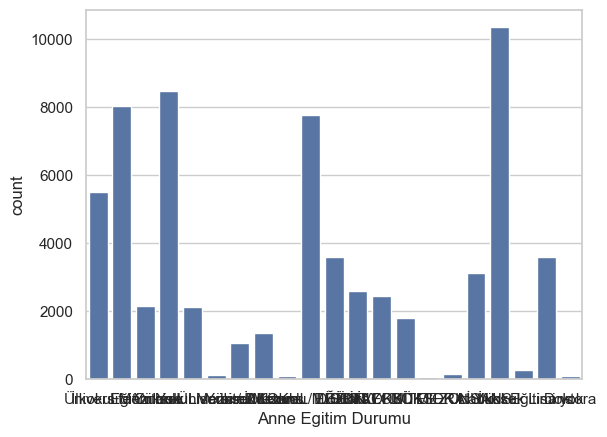

                     Anne Calisma Durumu  Ratio
Anne Calisma Durumu                            
Hayır                              39370 60.454
Evet                               10504 16.129
Emekli                              3354  5.150


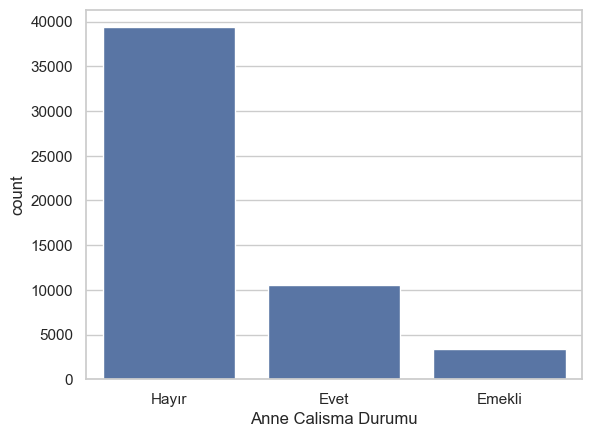

             Anne Sektor  Ratio
Anne Sektor                    
0                  11780 18.089
-                   5826  8.946
Özel Sektör         4425  6.795
Kamu                3805  5.843
ÖZEL SEKTÖR         1617  2.483
KAMU                1344  2.064
Diğer               1333  2.047
DİĞER                457  0.702


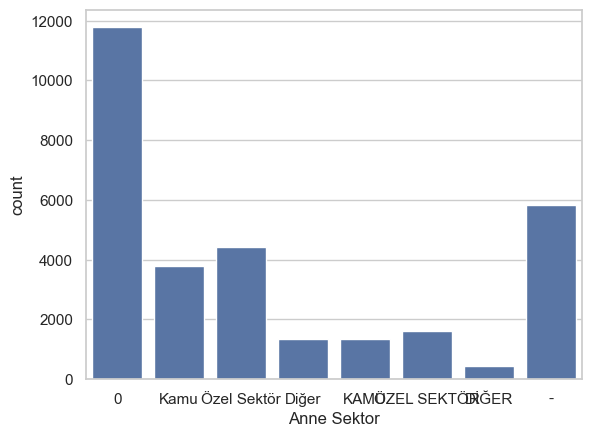

                         Baba Egitim Durumu  Ratio
Baba Egitim Durumu                                
Lise                                  10008 15.368
Üniversite                             9149 14.049
İlkokul                                8256 12.677
İLKOKUL MEZUNU                         5784  8.882
İlkokul Mezunu                         5389  8.275
LİSE                                   4482  6.882
ÜNİVERSİTE                             4258  6.538
Ortaokul                               4109  6.310
Ortaokul Mezunu                        2540  3.900
ORTAOKUL MEZUNU                        2531  3.886
Üniversite Mezunu                      1731  2.658
Lise Mezunu                            1405  2.157
Eğitimi yok                            1102  1.692
EĞİTİM YOK                              811  1.245
Yüksek Lisans                           596  0.915
Eğitim Yok                              585  0.898
YÜKSEK LİSANS                           367  0.564
Yüksek Lisans / Doktora        

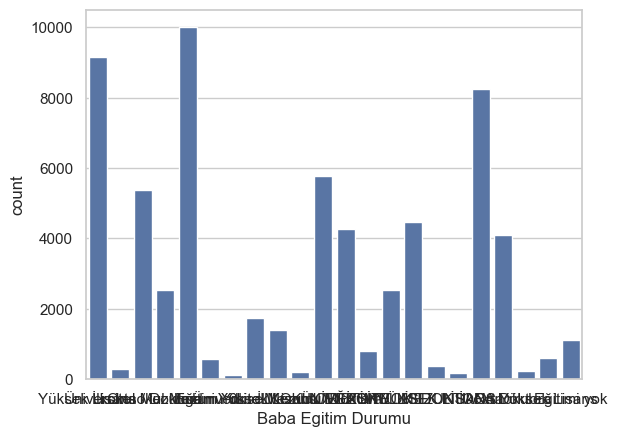

                     Baba Calisma Durumu  Ratio
Baba Calisma Durumu                            
Evet                               28558 43.852
Hayır                              12486 19.173
Emekli                             11462 17.600


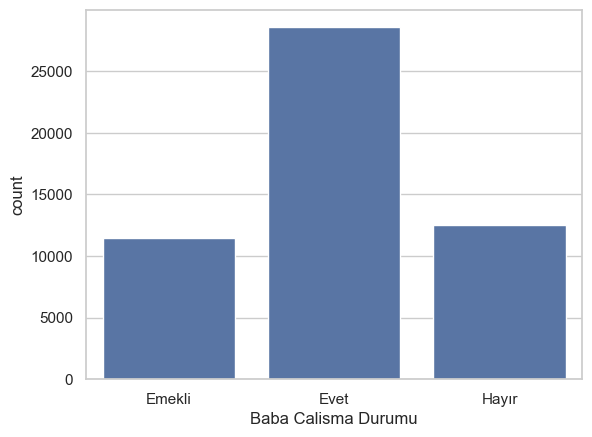

             Baba Sektor  Ratio
Baba Sektor                    
Özel Sektör        11293 17.341
Kamu                7457 11.450
Diğer               6716 10.313
0                   6631 10.182
ÖZEL SEKTÖR         4320  6.633
-                   3070  4.714
KAMU                2862  4.395
DİĞER               2397  3.681


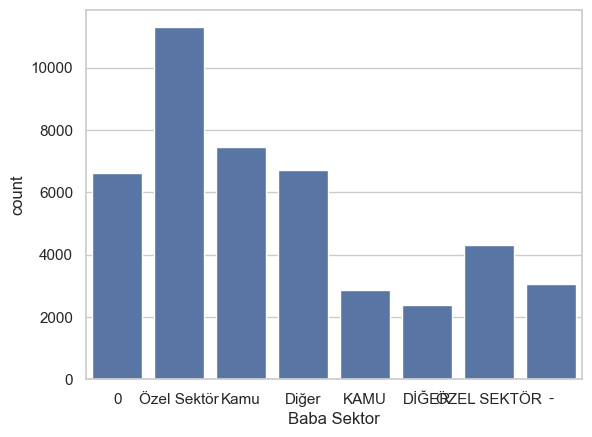

                                              Kardes Sayisi  Ratio
Kardes Sayisi                                                     
1.0                                                   16186 24.854
2.0                                                   13061 20.056
3.0                                                    6734 10.340
1                                                      6054  9.296
4.0                                                    4611  7.080
2                                                      3938  6.047
0.0                                                    3701  5.683
5.0                                                    3421  5.253
3                                                      2087  3.205
0                                                      1381  2.121
4                                                       998  1.532
5                                                       715  1.098
6.0                                                     206  0

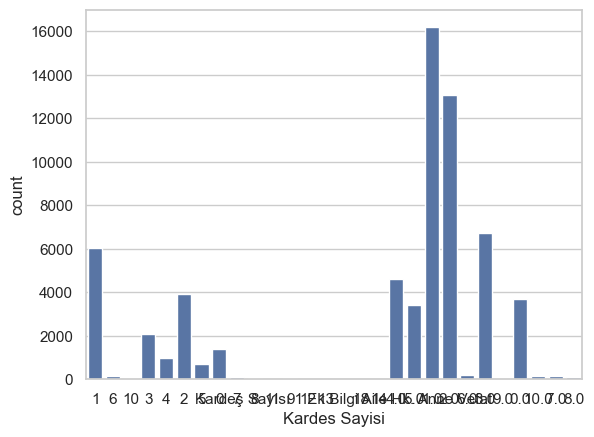

                                                    Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?  Ratio
Girisimcilik Kulupleri Tarzi Bir Kulube Uye mis...                                                             
Hayır                                                                                           33709    51.761
Evet                                                                                            29586    45.430


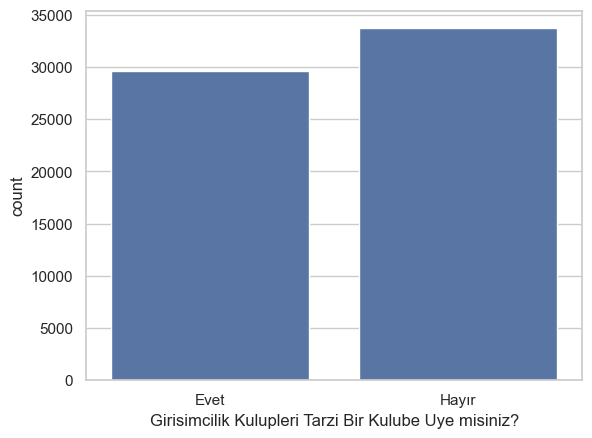

                                              Profesyonel Bir Spor Daliyla Mesgul musunuz?  Ratio
Profesyonel Bir Spor Daliyla Mesgul musunuz?                                                     
Hayır                                                                                42243 64.865
Evet                                                                                 21766 33.422


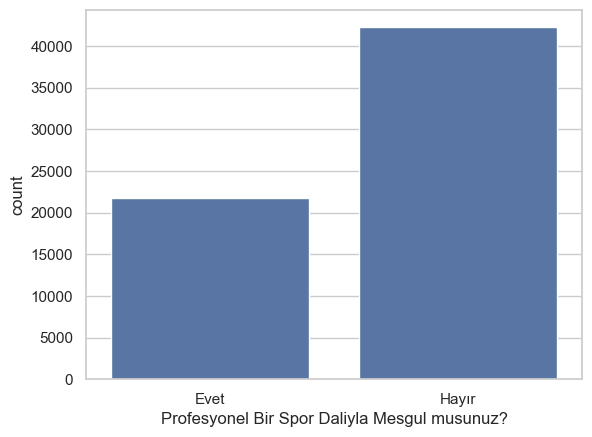

                               Spor Dalindaki Rolunuz Nedir?  Ratio
Spor Dalindaki Rolunuz Nedir?                                      
0                                                      11315 17.375
Diğer                                                   8836 13.568
-                                                       4173  6.408
Lider/Kaptan                                            1994  3.062
DİĞER                                                   1945  2.987
Bireysel                                                1697  2.606
Takım Oyuncusu                                          1174  1.803
Kaptan                                                   873  1.341
KAPTAN / LİDER                                           842  1.293


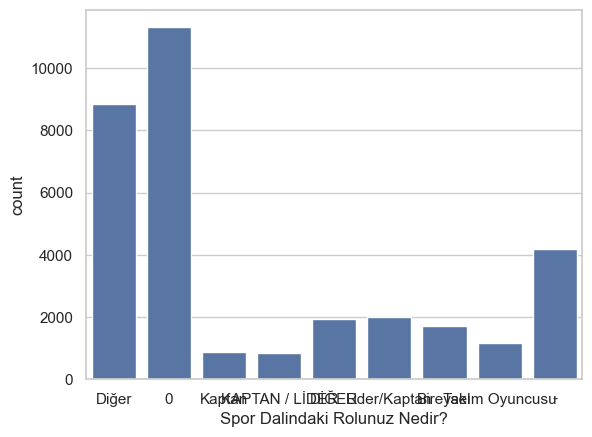

                                     Aktif olarak bir STK üyesi misiniz?  Ratio
Aktif olarak bir STK üyesi misiniz?                                            
Hayır                                                              37716 57.914
Evet                                                               14566 22.367


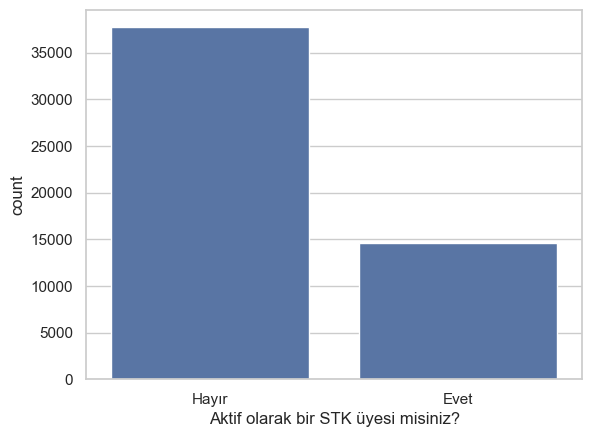

                              Stk Projesine Katildiniz Mi?  Ratio
Stk Projesine Katildiniz Mi?                                     
Hayır                                                19661 30.190
Evet                                                 17156 26.344


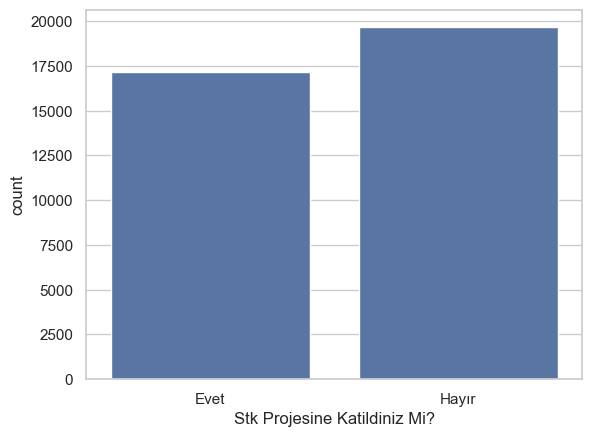

                                           Girisimcilikle Ilgili Deneyiminiz Var Mi?  Ratio
Girisimcilikle Ilgili Deneyiminiz Var Mi?                                                  
Hayır                                                                          33919 52.084
Evet                                                                           18365 28.200


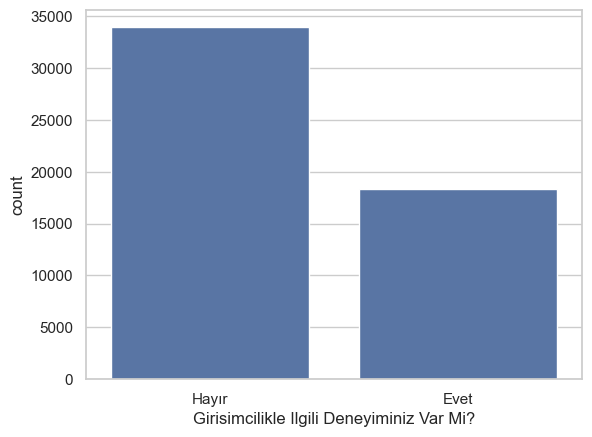

                            Ingilizce Biliyor musunuz?  Ratio
Ingilizce Biliyor musunuz?                                   
Evet                                             48871 75.043
Hayır                                             9799 15.047


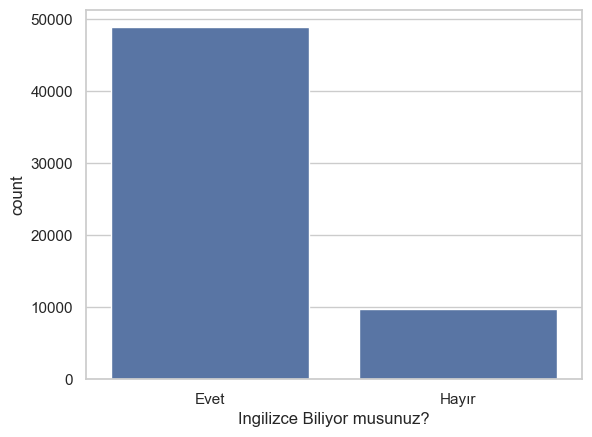

                      Ingilizce Seviyeniz?  Ratio
Ingilizce Seviyeniz?                             
Orta                                 13057 20.049
İleri                                 8318 12.773
Başlangıç                             5180  7.954
0                                     2037  3.128


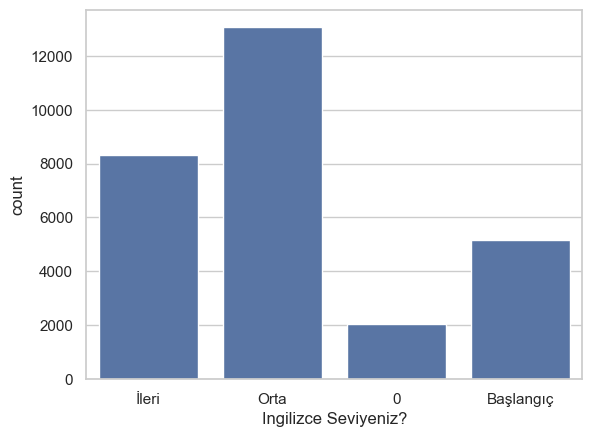

              Basvuru Yili  Ratio
Basvuru Yili                     
2021                 11594 17.803
2017                 10325 15.854
2015                  7804 11.983
2020                  7760 11.916
2022                  7621 11.702
2019                  7248 11.130
2014                  6454  9.910
2016                  5213  8.005
2018                  1105  1.697
2024-09-15 23:42:50,526 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

2024-09-15 23:42:50,572 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



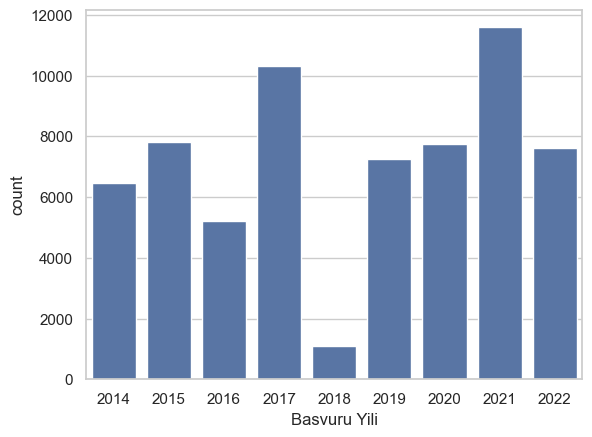

In [1487]:
for feature in cat_cols_eda:
        cat_summary(df_train, feature, True)
        #df_train.groupby(feature)['Degerlendirme Puani'].mean().plot.bar()
        #plt.title(feature + ' vs Degerlendirme puani')
        #plt.show()

                       Cinsiyet  Ratio
Cinsiyet                              
Kadın                      6378 57.725
Erkek                      4654 42.121
Belirtmek istemiyorum        17  0.154


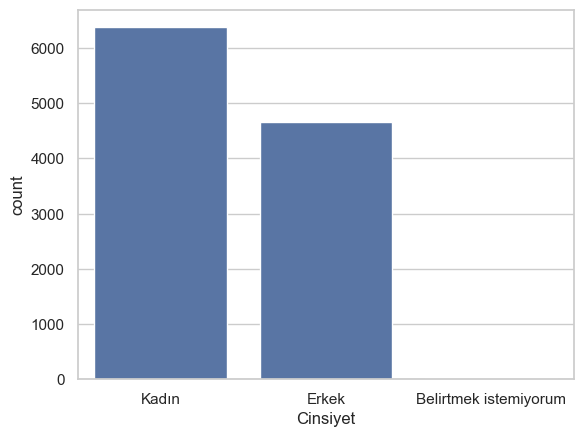

                 Universite Turu  Ratio
Universite Turu                        
Devlet                      9215 83.401
Özel                        1834 16.599


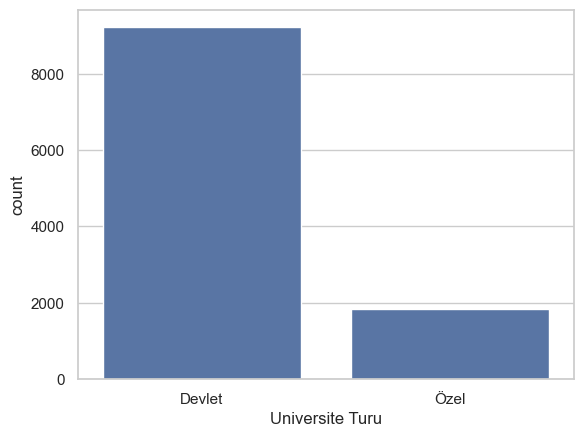

                 Burs Aliyor mu?  Ratio
Burs Aliyor mu?                        
Hayır                       9400 85.076
Evet                        1649 14.924


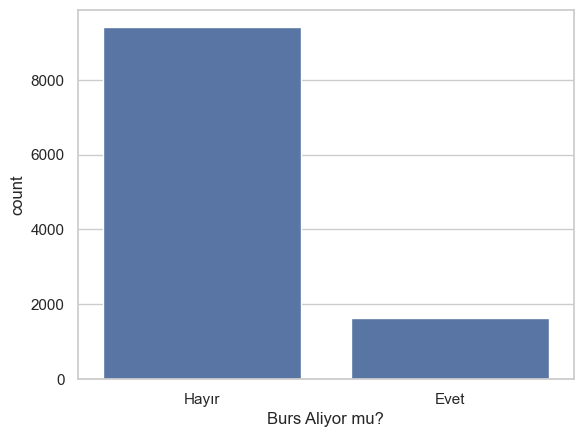

                          Universite Kacinci Sinif  Ratio
Universite Kacinci Sinif                                 
2                                             3315 30.003
3                                             3039 27.505
4                                             2466 22.319
1                                             1803 16.318
Hazırlık                                       233  2.109
5                                              164  1.484
6                                               29  0.262


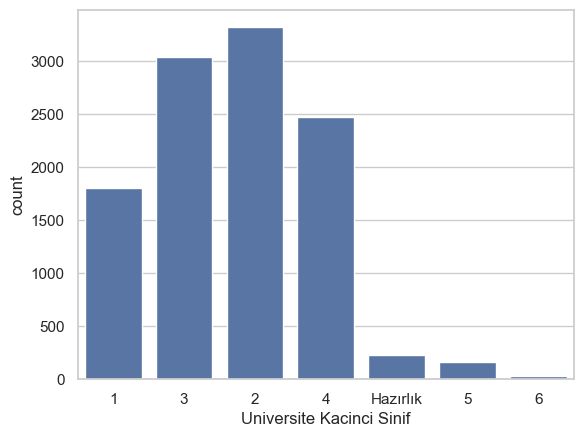

                           Universite Not Ortalamasi  Ratio
Universite Not Ortalamasi                                  
2.50 - 2.99                                     3605 32.627
3.00 - 3.49                                     3296 29.831
1.80 - 2.49                                     1742 15.766
Hazırlığım                                      1108 10.028
3.50 - 4.00                                     1007  9.114
0 - 1.79                                         291  2.634


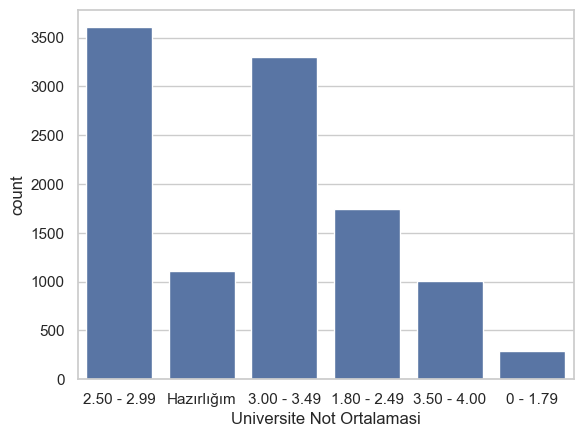

           Lise Turu  Ratio
Lise Turu                  
Devlet          9242 83.646
Özel            1807 16.354


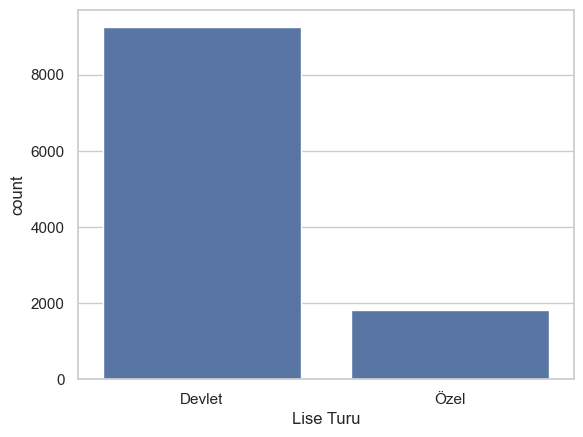

              Lise Bolumu  Ratio
Lise Bolumu                     
Sayısal              6354 57.507
Eşit Ağırlık         3224 29.179
Sözel                1152 10.426
Dil                   319  2.887


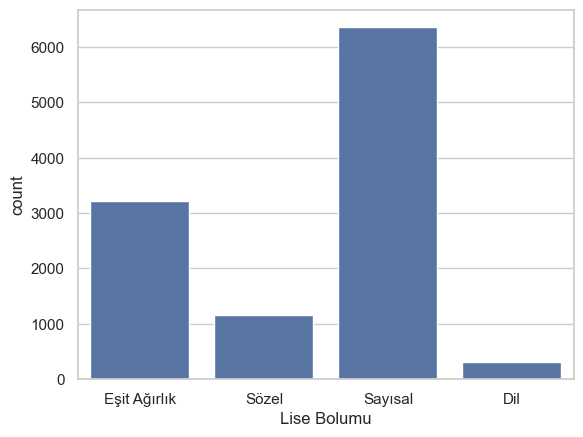

                     Lise Mezuniyet Notu  Ratio
Lise Mezuniyet Notu                            
75 - 100                            9742 88.171
50 - 74                             1301 11.775
25 - 49                                6  0.054


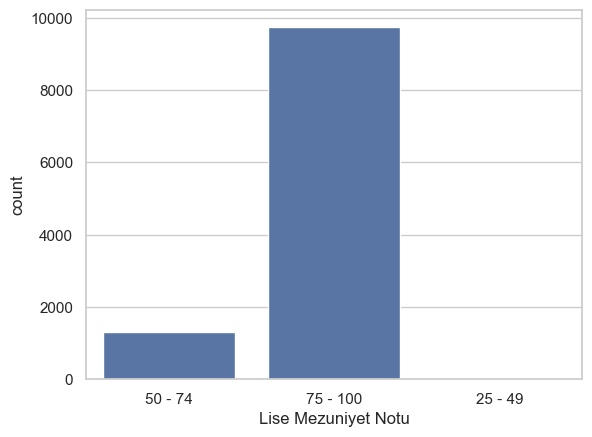

                                    Baska Bir Kurumdan Burs Aliyor mu?  Ratio
Baska Bir Kurumdan Burs Aliyor mu?                                           
Hayır                                                             6658 60.259
Evet                                                              4391 39.741


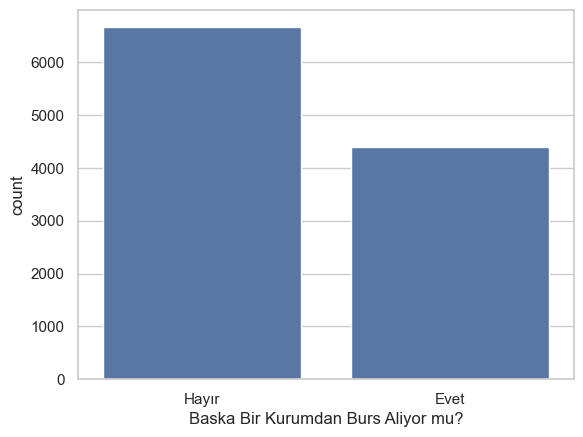

                                    Baska Kurumdan Aldigi Burs Miktari  Ratio
Baska Kurumdan Aldigi Burs Miktari                                           
-                                                                 6546 59.245
1000₺ ve üstü                                                     4110 37.198
500₺ - 999₺                                                        248  2.245
0 - 499 ₺                                                          145  1.312


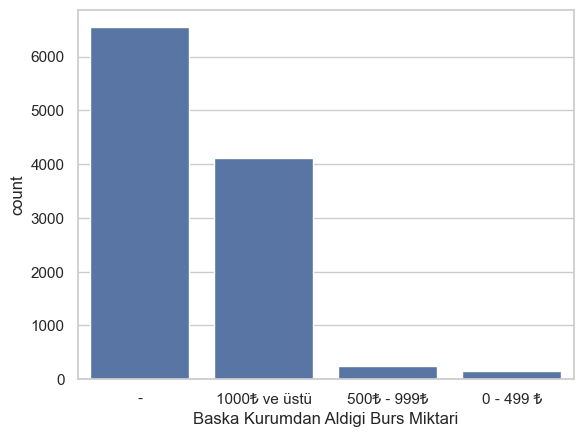

                    Anne Egitim Durumu  Ratio
Anne Egitim Durumu                           
İlkokul                           3977 35.994
Lise                              2362 21.378
Üniversite                        1798 16.273
Eğitimi yok                       1457 13.187
Ortaokul                          1272 11.512
Yüksek Lisans                      143  1.294
Doktora                             40  0.362


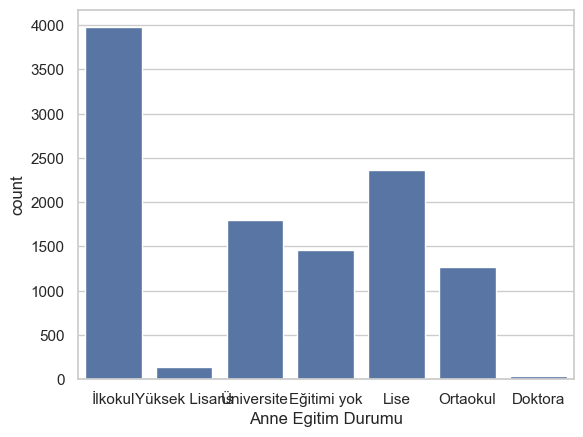

                     Anne Calisma Durumu  Ratio
Anne Calisma Durumu                            
Hayır                               8691 78.659
Evet                                2358 21.341


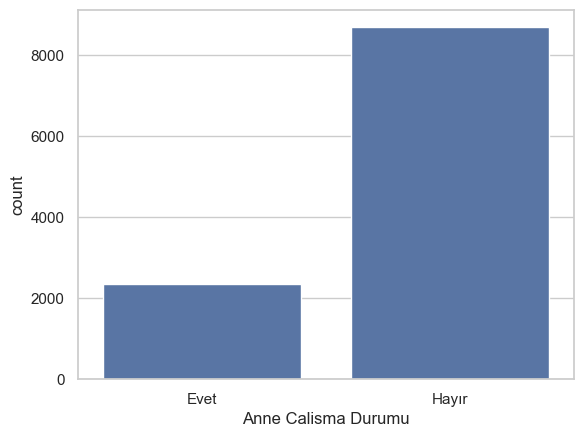

             Anne Sektor  Ratio
Anne Sektor                    
-                   8629 78.098
Özel Sektör         1112 10.064
Kamu                 989  8.951
Diğer                319  2.887


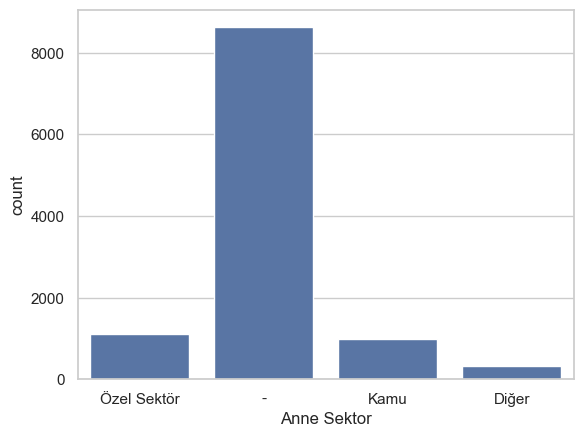

                    Baba Egitim Durumu  Ratio
Baba Egitim Durumu                           
İlkokul                           3144 28.455
Üniversite                        2728 24.690
Lise                              2706 24.491
Ortaokul                          1666 15.078
Eğitimi yok                        427  3.865
Yüksek Lisans                      272  2.462
Doktora                            106  0.959


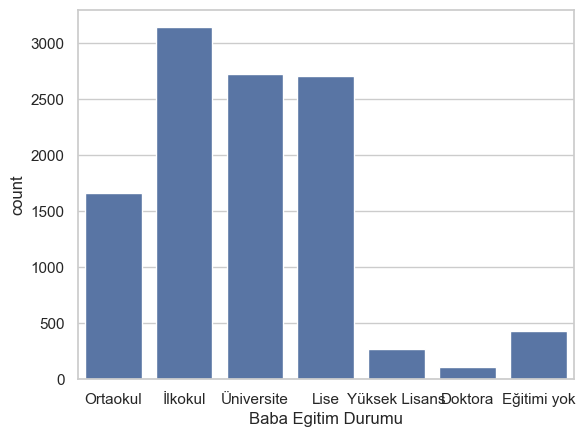

                     Baba Calisma Durumu  Ratio
Baba Calisma Durumu                            
Evet                                6177 55.906
Hayır                               4872 44.094


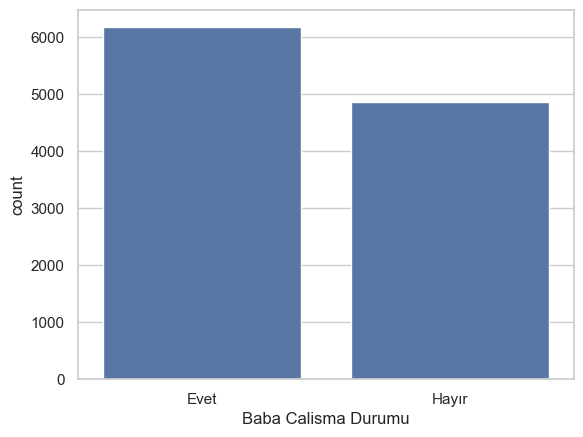

             Baba Sektor  Ratio
Baba Sektor                    
-                   4752 43.008
Özel Sektör         2793 25.278
Diğer               1804 16.327
Kamu                1700 15.386


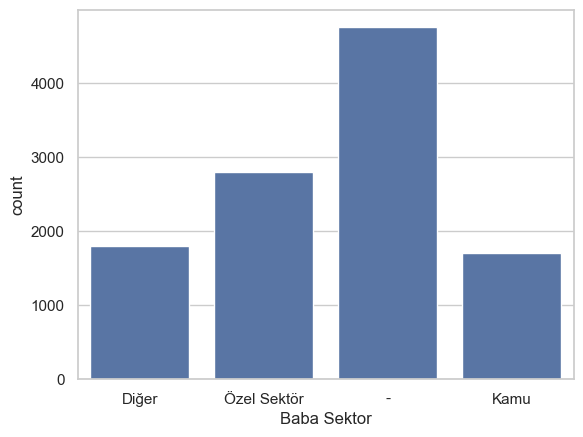

                                                    Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?  Ratio
Girisimcilik Kulupleri Tarzi Bir Kulube Uye mis...                                                             
Hayır                                                                                            5940    53.761
Evet                                                                                             5109    46.239


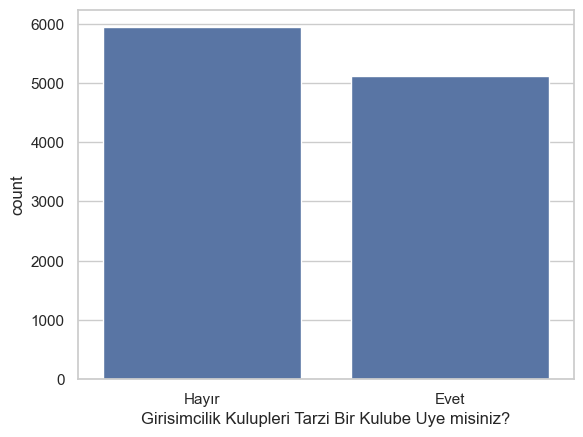

                                              Profesyonel Bir Spor Daliyla Mesgul musunuz?  Ratio
Profesyonel Bir Spor Daliyla Mesgul musunuz?                                                     
Hayır                                                                                 6422 58.123
Evet                                                                                  4627 41.877


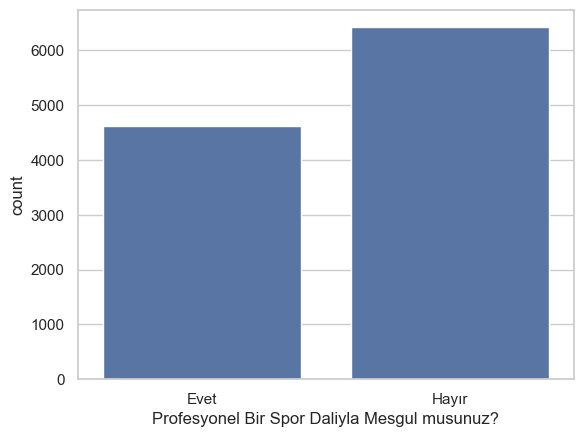

                               Spor Dalindaki Rolunuz Nedir?  Ratio
Spor Dalindaki Rolunuz Nedir?                                      
-                                                       6319 57.191
Bireysel Spor                                           2509 22.708
Takım Oyuncusu                                          1428 12.924
Lider/Kaptan                                             528  4.779
Diğer                                                    265  2.398


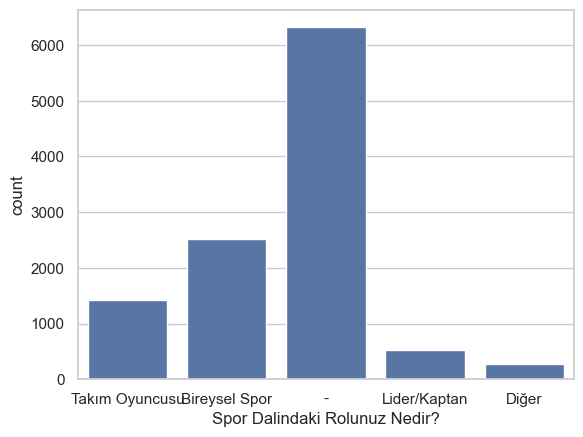

                                     Aktif olarak bir STK üyesi misiniz?  Ratio
Aktif olarak bir STK üyesi misiniz?                                            
Evet                                                                6270 56.747
Hayır                                                               4779 43.253


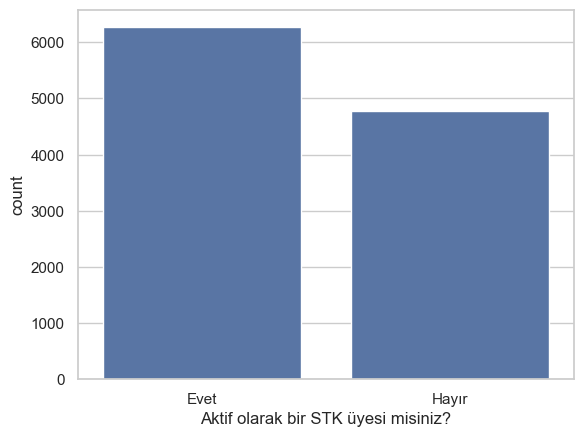

                                           Girisimcilikle Ilgili Deneyiminiz Var Mi?  Ratio
Girisimcilikle Ilgili Deneyiminiz Var Mi?                                                  
Hayır                                                                           7796 70.558
Evet                                                                            3253 29.442


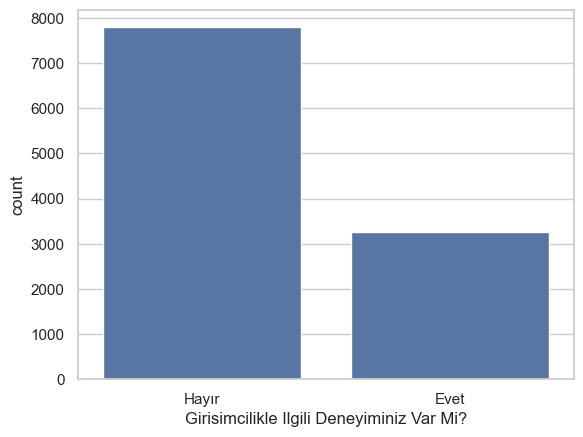

                            Ingilizce Biliyor musunuz?  Ratio
Ingilizce Biliyor musunuz?                                   
Evet                                              8863 80.215
Hayır                                             2186 19.785


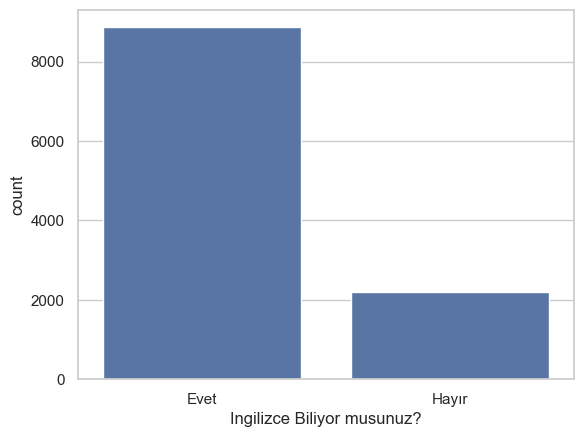

              Basvuru Yili   Ratio
Basvuru Yili                      
2023                 11049 100.000
2024-09-15 23:42:55,273 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

2024-09-15 23:42:55,284 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



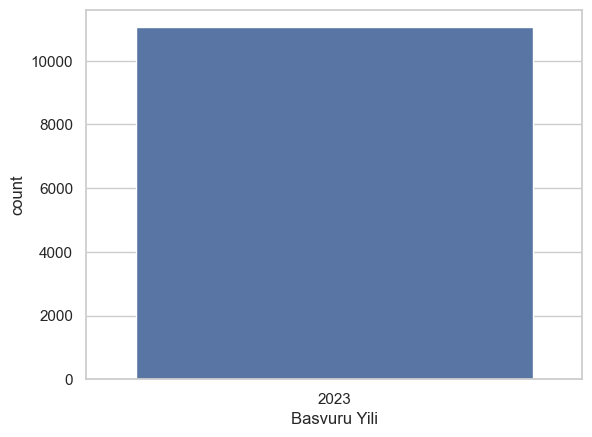

Empty DataFrame
Columns: [Burslu ise Burs Yuzdesi, Ratio]
Index: []


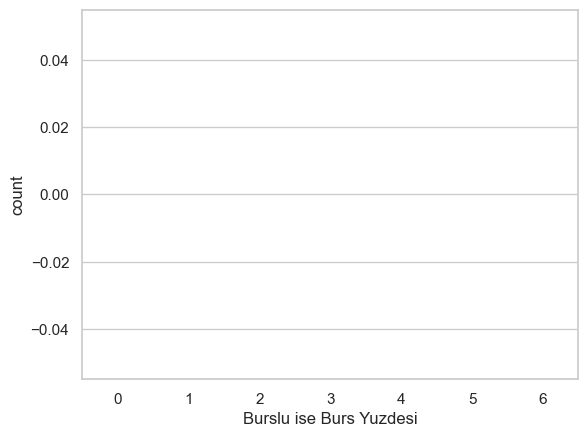

Empty DataFrame
Columns: [Daha Once Baska Bir Universiteden Mezun Olmus, Ratio]
Index: []


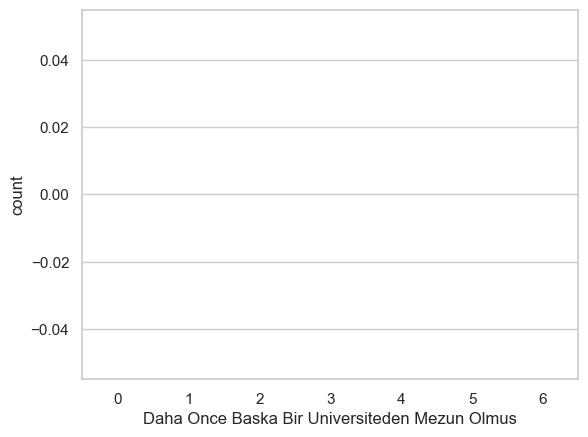

Empty DataFrame
Columns: [Lise Adi Diger, Ratio]
Index: []


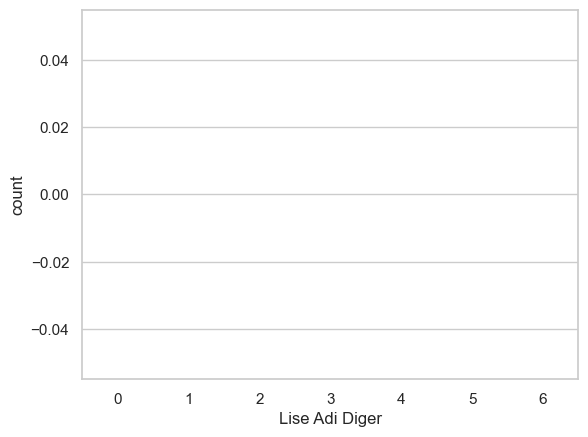

Empty DataFrame
Columns: [Lise Bolum Diger, Ratio]
Index: []


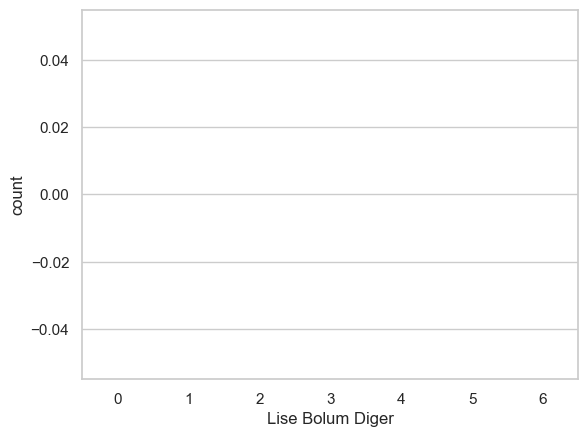

               Kardes Sayisi  Ratio
Kardes Sayisi                      
1.000                   3612 32.691
2.000                   2821 25.532
4.000                   2421 21.911
3.000                   1490 13.485
0.000                    705  6.381
2024-09-15 23:42:56,187 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

2024-09-15 23:42:56,198 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



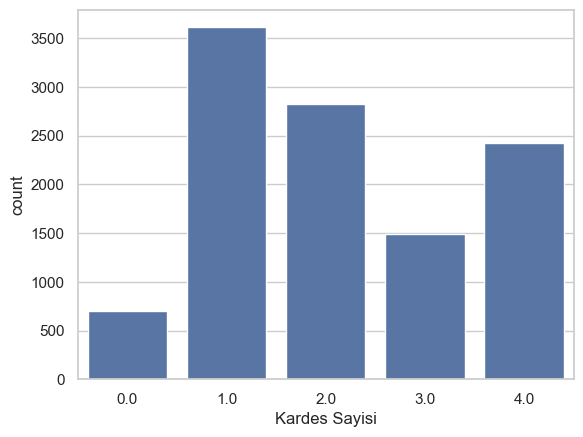

Empty DataFrame
Columns: [Uye Oldugunuz Kulubun Ismi, Ratio]
Index: []


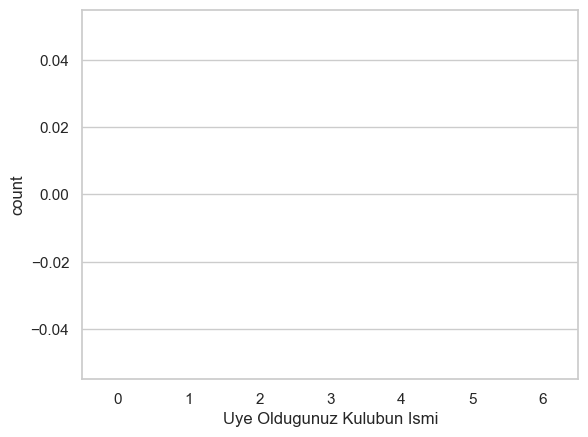

Empty DataFrame
Columns: [Stk Projesine Katildiniz Mi?, Ratio]
Index: []


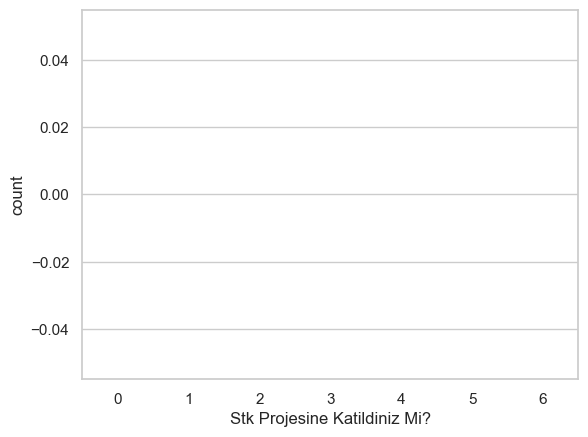

Empty DataFrame
Columns: [Ingilizce Seviyeniz?, Ratio]
Index: []


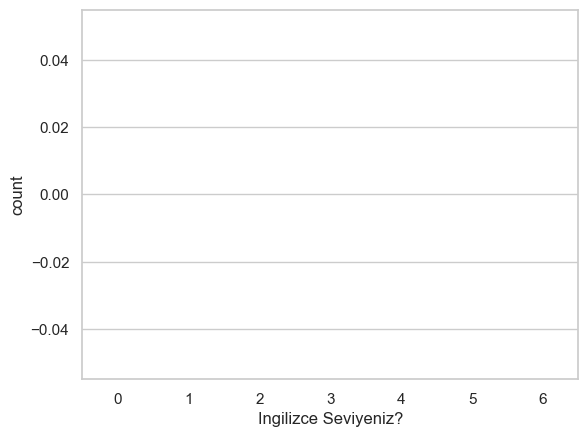

Empty DataFrame
Columns: [Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite, Ratio]
Index: []


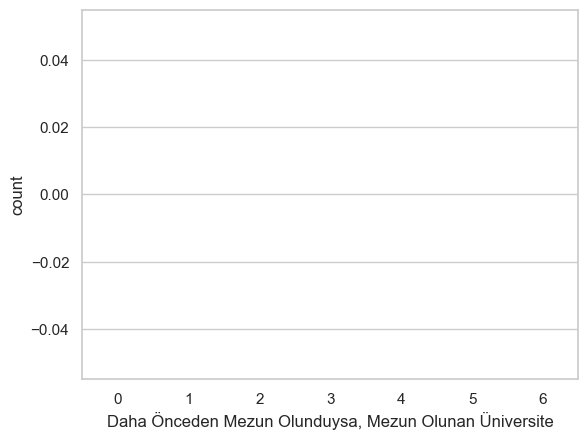

In [1488]:
for feature in cat_cols_test:
        cat_summary(df_test, feature, True)

count   65124.000
mean       32.086
std        18.139
min         0.000
5%          7.000
10%        10.000
20%        15.000
30%        20.000
40%        24.000
50%        29.000
60%        34.000
70%        40.000
80%        48.000
90%        58.000
95%        66.000
99%        78.000
max       102.000
Name: Degerlendirme Puani, dtype: float64


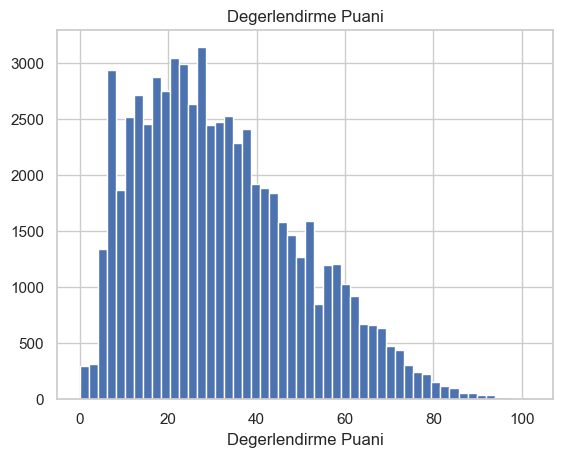

#####################################
count   22440.000
mean       34.226
std        41.632
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%        50.000
70%        50.000
80%       100.000
90%       100.000
95%       100.000
99%       100.000
max       100.000
Name: Burslu ise Burs Yuzdesi, dtype: float64


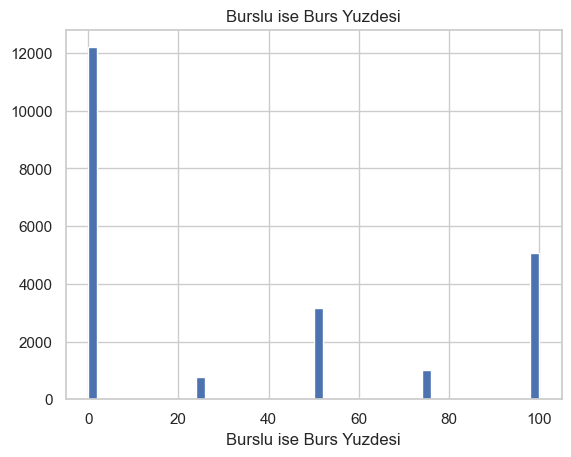

#####################################
count   65124.000
mean    32561.500
std     18799.824
min         0.000
5%       3256.150
10%      6512.300
20%     13024.600
30%     19536.900
40%     26049.200
50%     32561.500
60%     39073.800
70%     45586.100
80%     52098.400
90%     58610.700
95%     61866.850
99%     64471.770
max     65123.000
Name: id, dtype: float64


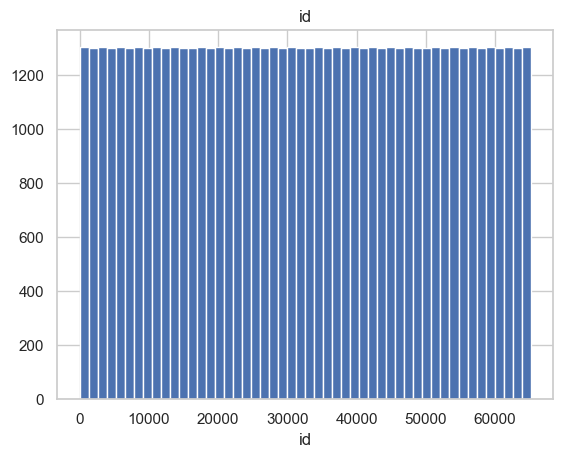

#####################################


In [1489]:
for col in num_cols_eda:
    num_summary(df_train, col, True)

In [1490]:
for col in cat_cols_eda:
    target_summary_with_cat(df_train, 'Degerlendirme Puani', col)

                       TARGET_MEAN
Cinsiyet                          
Belirtmek istemiyorum       30.165
ERKEK                       25.591
Erkek                       34.535
Kadın                       32.437


                 TARGET_MEAN
Universite Turu             
DEVLET                24.368
Devlet                33.726
ÖZEL                  29.064
Özel                  40.244


                 TARGET_MEAN
Burs Aliyor mu?             
EVET                  27.954
Evet                  38.482
Hayır                 31.214
evet                  33.126
hayır                 32.702


                          TARGET_MEAN
Universite Kacinci Sinif             
0                              22.667
1                              27.934
2                              30.015
3                              34.694
4                              35.913
5                              35.374
6                              32.808
Hazırlık                       27.431
Mezun                      

In [1491]:
def return_data_to_be_compared(dataframe, cols):
    guide_df = pd.DataFrame()  # Boş DataFrame oluştur
    for col in cols:
        guide_df[col] = [list(dataframe[col].unique())]  # Benzersiz değerleri liste olarak ekle
    return guide_df

In [1492]:
cat_guide_df = return_data_to_be_compared(df_test, cat_cols_test)

In [1493]:
cat_guide_df

,Cinsiyet,Universite Turu,Burs Aliyor mu?,Universite Kacinci Sinif,Universite Not Ortalamasi,Lise Turu,Lise Bolumu,Lise Mezuniyet Notu,Baska Bir Kurumdan Burs Aliyor mu?,Baska Kurumdan Aldigi Burs Miktari,Anne Egitim Durumu,Anne Calisma Durumu,Anne Sektor,Baba Egitim Durumu,Baba Calisma Durumu,Baba Sektor,Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?,Profesyonel Bir Spor Daliyla Mesgul musunuz?,Spor Dalindaki Rolunuz Nedir?,Aktif olarak bir STK üyesi misiniz?,Girisimcilikle Ilgili Deneyiminiz Var Mi?,Ingilizce Biliyor musunuz?,Basvuru Yili,Burslu ise Burs Yuzdesi,Daha Once Baska Bir Universiteden Mezun Olmus,Lise Adi Diger,Lise Bolum Diger,Kardes Sayisi,Uye Oldugunuz Kulubun Ismi,Stk Projesine Katildiniz Mi?,Ingilizce Seviyeniz?,"Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite"
0,"[Kadın, Erkek, Belirtmek istemiyorum]","[Devlet, Özel]","[Hayır, Evet]","[1, 3, 2, 4, Hazırlık, 5, 6]","[2.50 - 2.99, Hazırlığım, 3.00 - 3.49, 1.80 - ...","[Devlet, Özel]","[Eşit Ağırlık, Sözel, Sayısal, Dil]","[50 - 74, 75 - 100, 25 - 49]","[Hayır, Evet]","[-, 1000₺ ve üstü, 500₺ - 999₺, 0 - 499 ₺]","[İlkokul, Yüksek Lisans, Üniversite, Eğitimi y...","[Evet, Hayır]","[Özel Sektör, -, Kamu, Diğer]","[Ortaokul, İlkokul, Üniversite, Lise, Yüksek L...","[Evet, Hayır]","[Diğer, Özel Sektör, -, Kamu]","[Hayır, Evet]","[Evet, Hayır]","[Takım Oyuncusu, Bireysel Spor, -, Lider/Kapta...","[Evet, Hayır]","[Hayır, Evet]","[Evet, Hayır]",[2023],[nan],[nan],[nan],[nan],"[2.0, 3.0, 0.0, 4.0, 1.0]",[nan],[nan],[nan],[nan]


In [1494]:
car_guide_df = return_data_to_be_compared(df_test, cat_but_car_test)

In [1495]:
car_guide_df

,Dogum Tarihi,Dogum Yeri,Ikametgah Sehri,Universite Adi,Bölüm,Lise Adi,Lise Sehir,Burs Aldigi Baska Kurum,Hangi STK'nin Uyesisiniz?,Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?
0,"[21.06.2002 00:00, 11.05.2004 00:00, 24.04.200...","[Amasya, Konya, İstanbul, Mardin, Samsun, Ispa...","[Amasya, Konya, İstanbul, Mardin, İzmir, Kırşe...","[Munzur Üniversitesi, Hacettepe Üniversitesi, ...","[Sosyal Hizmet, Uluslararası İlişkiler, Diğer,...",[Amasya Suluova Şehit Muharrem Saygun Anadolu ...,"[Amasya, Konya, İstanbul, Mardin, Samsun, Ispa...","[-, KYK, Toplum Gönüllüleri Vakfı, Devlet, KYK...","[Kızılay da gönüllü dağıtım, -, Lise gezilerde...","[-, 12 aydır, yolculuğuna bir yıl önce başlamı..."


In [1496]:
universities = [
    # Türkiye'deki devlet ve vakıf üniversiteleri
    "Abant İzzet Baysal Üniversitesi", 
    "Acıbadem Mehmet Ali Aydınlar Üniversitesi", 
    "Adana Alparslan Türkeş Bilim ve Teknoloji Üniversitesi", 
    "Adıyaman Üniversitesi", 
    "Afyon Kocatepe Üniversitesi", 
    "Afyonkarahisar Sağlık Bilimleri Üniversitesi",  # Eklendi
    "Ağrı İbrahim Çeçen Üniversitesi", 
    "Aksaray Üniversitesi", 
    "Amasya Üniversitesi",  # Eklendi
    "Ankara Jandarma ve Sahil Güvenlik Akademisi (Askerî)",  # Eklendi
    "Ankara Üniversitesi", 
    "Ankara Müzik ve Güzel Sanatlar Üniversitesi",  # Eklendi
    "Ankara Hacı Bayram Veli Üniversitesi", 
    "Ankara Sosyal Bilimler Üniversitesi", 
    "Ankara Yıldırım Beyazıt Üniversitesi",  # Eklendi
    "Polis Akademisi", 
    "Antalya Bilim Üniversitesi", 
    "Atatürk Üniversitesi", 
    "Avrasya Üniversitesi"
    "Bahçeşehir Üniversitesi", 
    "Bandırma Onyedi Eylül Üniversitesi", 
    "Bartın Üniversitesi", 
    "Başkent Üniversitesi", 
    "Batman Üniversitesi", 
    "Bayburt Üniversitesi", 
    "Bezmialem Vakıf Üniversitesi", 
    "Beykent Üniversitesi", 
    "Beykoz Üniversitesi", 
    "Biruni Üniversitesi", 
    "Boğaziçi Üniversitesi", 
    "Bolu Abant İzzet Baysal Üniversitesi", 
    "Bursa Teknik Üniversitesi", 
    "Bursa Uludağ Üniversitesi", 
    "Çağ Üniversitesi", 
    "Çankaya Üniversitesi", 
    "Çankırı Karatekin Üniversitesi", 
    "Çorum Hitit Üniversitesi",  # Eklendi
    "Çukurova Üniversitesi", 
    "Demiroğlu Bilim Üniversitesi", 
    "Dicle Üniversitesi", 
    "Doğuş Üniversitesi", 
    "Dokuz Eylül Üniversitesi", 
    "Ege Üniversitesi", 
    "Erciyes Üniversitesi", 
    "Erzincan Binali Yıldırım Üniversitesi", 
    "Erzurum Teknik Üniversitesi", 
    "Eskişehir Osmangazi Üniversitesi", 
    "Fenerbahçe Üniversitesi", 
    "Fırat Üniversitesi", 
    "Galatasaray Üniversitesi", 
    "Gaziantep Üniversitesi", 
    "Gebze Teknik Üniversitesi", 
    "Giresun Üniversitesi", 
    "Hacettepe Üniversitesi", 
    "Haliç Üniversitesi", 
    "Iğdır Üniversitesi", 
    "İbn Haldun Üniversitesi", 
    "İhsan Doğramacı Bilkent Üniversitesi", 
    "İstanbul Arel Üniversitesi", 
    "İstanbul Bilgi Üniversitesi", 
    "İstanbul Esenyurt Üniversitesi", 
    "İstanbul Gelişim Üniversitesi", 
    "İstanbul Kent Üniversitesi", 
    "İstanbul Kültür Üniversitesi", 
    "İstanbul Medeniyet Üniversitesi", 
    "İstanbul Medipol Üniversitesi", 
    "İstanbul Rumeli Üniversitesi", 
    "İstanbul Sabahattin Zaim Üniversitesi", 
    "İstanbul Teknik Üniversitesi", 
    "İstanbul Ticaret Üniversitesi", 
    "İstanbul Üniversitesi", 
    "İstanbul Üniversitesi-Cerrahpaşa", 
    "İzmir Bakırçay Üniversitesi", 
    "İzmir Demokrasi Üniversitesi", 
    "İzmir Ekonomi Üniversitesi", 
    "İzmir Kâtip Çelebi Üniversitesi", 
    "Kadir Has Üniversitesi", 
    "Kafkas Üniversitesi", 
    "Kahramanmaraş Sütçü İmam Üniversitesi", 
    "Karabük Üniversitesi", 
    "Karadeniz Teknik Üniversitesi", 
    "Karamanoğlu Mehmetbey Üniversitesi", 
    "Kastamonu Üniversitesi", 
    "Kayseri Abdullah Gül Üniversitesi",  # Eklendi
    "Kayseri Üniversitesi",  # Eklendi
    "Kocaeli Üniversitesi", 
    "Koç Üniversitesi", 
    "KTO Karatay Üniversitesi", 
    "Kırklareli Üniversitesi",
    "Kırıkkale Üniversitesi",
    "Maltepe Üniversitesi", 
    "Manisa Celal Bayar Üniversitesi", 
    "Marmara Üniversitesi", 
    "Mersin Üniversitesi", 
    "Mimar Sinan Güzel Sanatlar Üniversitesi", 
    "Muğla Sıtkı Koçman Üniversitesi", 
    "Necmettin Erbakan Üniversitesi", 
    "Niğde Ömer Halisdemir Üniversitesi", 
    "Ondokuz Mayıs Üniversitesi", 
    "Orta Doğu Teknik Üniversitesi", 
    "Osmaniye Korkut Ata Üniversitesi", 
    "Özyeğin Üniversitesi", 
    "Pamukkale Üniversitesi", 
    "Piri Reis Üniversitesi", 
    "Recep Tayyip Erdoğan Üniversitesi", 
    "Sabancı Üniversitesi", 
    "Sakarya Üniversitesi", 
    "Selçuk Üniversitesi", 
    "Süleyman Demirel Üniversitesi", 
    "TED Üniversitesi", 
    "Trakya Üniversitesi", 
    "Ufuk Üniversitesi", 
    "Üsküdar Üniversitesi", 
    "Van Yüzüncü Yıl Üniversitesi", 
    "Yalova Üniversitesi", 
    "Yeditepe Üniversitesi", 
    "Yeni Yüzyıl Üniversitesi", 
    "Yıldız Teknik Üniversitesi", 
    "Yaşar Üniversitesi", 
    "Zonguldak Bülent Ecevit Üniversitesi",
    "Nuh Naci Yazgan Üniversitesi",
    "Zirve Üniversitesi",
    "İstanbul Şehir Üniversitesi",
    "İzmir Üniversitesi",
    "Okan Üniversitesi",
    "Işık Üniversitesi",
    "Fatih Üniversitesi",
    "Fatih Sultan Mehmet Vakıf Üniversitesi",
    "Nişantaşı Üniversitesi",
    "Malatya Turgut Özal Üniversitesi",
    "İnönü Üniversitesi",
    "Atılım Üniversitesi",
    "MEF Üniversitesi"
    

    # KKTC'deki üniversiteler
    "Doğu Akdeniz Üniversitesi", 
    "Girne Amerikan Üniversitesi", 
    "Yakın Doğu Üniversitesi", 
    "Uluslararası Kıbrıs Üniversitesi", 
    "Lefke Avrupa Üniversitesi", 
    "Kıbrıs İlim Üniversitesi", 
    "Kıbrıs Sosyal Bilimler Üniversitesi", 
    "Kıbrıs Amerikan Üniversitesi", 
    "Kıbrıs Sağlık ve Toplum Bilimleri Üniversitesi", 
    "Girne Üniversitesi", 
    "Arkın Yaratıcı Sanatlar ve Tasarım Üniversitesi", 
    "Bahçeşehir Kıbrıs Üniversitesi", 
    "Rauf Denktaş Üniversitesi", 
    "Ada Kent Üniversitesi", 
    "Final Üniversitesi", 
    "Akdeniz Karpaz Üniversitesi"
]

previous_universities = [
    "Abant İzzet Baysal Üniversitesi", "Acıbadem Mehmet Ali Aydınlar Üniversitesi",
    "Adana Alparslan Türkeş Bilim ve Teknoloji Üniversitesi", "Adıyaman Üniversitesi",
    "Afyon Kocatepe Üniversitesi", "Afyonkarahisar Sağlık Bilimleri Üniversitesi",
    "Ağrı İbrahim Çeçen Üniversitesi", "Aksaray Üniversitesi", "Amasya Üniversitesi",
    "Ankara Jandarma ve Sahil Güvenlik Akademisi (Askerî)", "Ankara Üniversitesi",
    "Ankara Müzik ve Güzel Sanatlar Üniversitesi", "Ankara Hacı Bayram Veli Üniversitesi",
    "Ankara Sosyal Bilimler Üniversitesi", "Ankara Yıldırım Beyazıt Üniversitesi",
    "Polis Akademisi", "Antalya Bilim Üniversitesi", "Atatürk Üniversitesi",
    "Avrasya Üniversitesi", "Bahçeşehir Üniversitesi", "Bandırma Onyedi Eylül Üniversitesi",
    "Bartın Üniversitesi", "Başkent Üniversitesi", "Batman Üniversitesi", "Bayburt Üniversitesi",
    "Bezmialem Vakıf Üniversitesi", "Beykent Üniversitesi", "Beykoz Üniversitesi",
    "Biruni Üniversitesi", "Boğaziçi Üniversitesi", "Bolu Abant İzzet Baysal Üniversitesi",
    "Bursa Teknik Üniversitesi", "Bursa Uludağ Üniversitesi", "Çağ Üniversitesi",
    "Çankaya Üniversitesi", "Çankırı Karatekin Üniversitesi", "Çorum Hitit Üniversitesi",
    "Çukurova Üniversitesi", "Demiroğlu Bilim Üniversitesi", "Dicle Üniversitesi",
    "Doğuş Üniversitesi", "Dokuz Eylül Üniversitesi", "Ege Üniversitesi", "Erciyes Üniversitesi",
    "Erzincan Binali Yıldırım Üniversitesi", "Erzurum Teknik Üniversitesi",
    "Eskişehir Osmangazi Üniversitesi", "Fenerbahçe Üniversitesi", "Fırat Üniversitesi",
    "Galatasaray Üniversitesi", "Gaziantep Üniversitesi", "Gebze Teknik Üniversitesi",
    "Giresun Üniversitesi", "Hacettepe Üniversitesi", "Haliç Üniversitesi", "Iğdır Üniversitesi",
    "İbn Haldun Üniversitesi", "İhsan Doğramacı Bilkent Üniversitesi", "İstanbul Arel Üniversitesi",
    "İstanbul Bilgi Üniversitesi", "İstanbul Esenyurt Üniversitesi", "İstanbul Gelişim Üniversitesi",
    "İstanbul Kent Üniversitesi", "İstanbul Kültür Üniversitesi", "İstanbul Medeniyet Üniversitesi",
    "İstanbul Medipol Üniversitesi", "İstanbul Rumeli Üniversitesi", "İstanbul Sabahattin Zaim Üniversitesi",
    "İstanbul Teknik Üniversitesi", "İstanbul Ticaret Üniversitesi", "İstanbul Üniversitesi",
    "İstanbul Üniversitesi-Cerrahpaşa", "İzmir Bakırçay Üniversitesi", "İzmir Demokrasi Üniversitesi",
    "İzmir Ekonomi Üniversitesi", "İzmir Kâtip Çelebi Üniversitesi", "Kadir Has Üniversitesi",
    "Kafkas Üniversitesi", "Kahramanmaraş Sütçü İmam Üniversitesi", "Karabük Üniversitesi",
    "Karadeniz Teknik Üniversitesi", "Karamanoğlu Mehmetbey Üniversitesi", "Kastamonu Üniversitesi",
    "Kayseri Abdullah Gül Üniversitesi", "Kayseri Üniversitesi", "Kocaeli Üniversitesi",
    "Koç Üniversitesi", "KTO Karatay Üniversitesi", "Maltepe Üniversitesi", "Manisa Celal Bayar Üniversitesi",
    "Marmara Üniversitesi", "Mersin Üniversitesi", "Mimar Sinan Güzel Sanatlar Üniversitesi",
    "Muğla Sıtkı Koçman Üniversitesi", "Necmettin Erbakan Üniversitesi", "Niğde Ömer Halisdemir Üniversitesi",
    "Ondokuz Mayıs Üniversitesi", "Orta Doğu Teknik Üniversitesi", "Osmaniye Korkut Ata Üniversitesi",
    "Özyeğin Üniversitesi", "Pamukkale Üniversitesi", "Piri Reis Üniversitesi", "Recep Tayyip Erdoğan Üniversitesi",
    "Sabancı Üniversitesi", "Sakarya Üniversitesi", "Selçuk Üniversitesi", "Süleyman Demirel Üniversitesi",
    "TED Üniversitesi", "Trakya Üniversitesi", "Ufuk Üniversitesi", "Üsküdar Üniversitesi",
    "Van Yüzüncü Yıl Üniversitesi", "Yalova Üniversitesi", "Yeditepe Üniversitesi", "Yeni Yüzyıl Üniversitesi",
    "Yıldız Teknik Üniversitesi", "Yaşar Üniversitesi", "Zonguldak Bülent Ecevit Üniversitesi",
    "Nuh Naci Yazgan Üniversitesi", "Zirve Üniversitesi", "İstanbul Şehir Üniversitesi", "İzmir Üniversitesi",
    "Okan Üniversitesi", "Işık Üniversitesi", "Fatih Üniversitesi", "Fatih Sultan Mehmet Vakıf Üniversitesi",
    "Nişantaşı Üniversitesi", "Malatya Turgut Özal Üniversitesi", "İnönü Üniversitesi", "Atılım Üniversitesi",
    "MEF Üniversitesi"
]

# Yeni liste
new_universities = [
    "Munzur Üniversitesi", "Hacettepe Üniversitesi", "Kapadokya Üniversitesi",
    "Mardin Artuklu Üniversitesi", "Boğaziçi Üniversitesi", "İzmir Yüksek Teknoloji Enstitüsü",
    "Kırşehir Ahi Evran Üniversitesi", "Yıldız Teknik Üniversitesi", "Necmettin Erbakan Üniversitesi",
    "Bursa Uludağ Üniversitesi", "MEF Üniversitesi", "Eskişehir Teknik Üniversitesi",
    "İstanbul Üniversitesi-Cerrahpaşa", "Gazi Üniversitesi", "Tekirdağ Namık Kemal Üniversitesi",
    "Gaziantep Üniversitesi", "Koç Üniversitesi", "Ankara Hacı Bayram Veli Üniversitesi",
    "Çukurova Üniversitesi", "Kütahya Dumlupınar Üniversitesi", "Ankara Bilim Üniversitesi",
    "Dicle Üniversitesi", "Dokuz Eylül Üniversitesi", "Siirt Üniversitesi", "Kilis 7 Aralık Üniversitesi",
    "Çanakkale Onsekiz Mart Üniversitesi", "Sivas Cumhuriyet Üniversitesi", "Tokat Gaziosmanpaşa Üniversitesi",
    "Nişantaşı Üniversitesi", "Özyeğin Üniversitesi", "Malatya Turgut Özal Üniversitesi",
    "Muğla Sıtkı Koçman Üniversitesi", "Akdeniz Üniversitesi", "İnönü Üniversitesi", "İstanbul Üniversitesi",
    "Orta Doğu Teknik Üniversitesi", "Giresun Üniversitesi", "İstanbul Medeniyet Üniversitesi",
    "Sabancı Üniversitesi", "Fırat Üniversitesi", "Batman Üniversitesi", "İstanbul Aydın Üniversitesi",
    "Abdullah Gül Üniversitesi", "İstanbul Teknik Üniversitesi", "Biruni Üniversitesi", "Atatürk Üniversitesi",
    "Samsun Üniversitesi", "Anadolu Üniversitesi", "İstanbul Atlas Üniversitesi", "Mersin Üniversitesi",
    "Doğuş Üniversitesi", "Beykent Üniversitesi", "İstanbul Medipol Üniversitesi", "Erciyes Üniversitesi",
    "Ondokuz Mayıs Üniversitesi", "Artvin Çoruh Üniversitesi", "Adıyaman Üniversitesi", "Gebze Teknik Üniversitesi",
    "İskenderun Teknik Üniversitesi", "İstinye Üniversitesi", "Kafkas Üniversitesi",
    "Bandırma Onyedi Eylül Üniversitesi", "Kastamonu Üniversitesi", "Harran Üniversitesi", "Balıkesir Üniversitesi",
    "Ankara Yıldırım Beyazıt Üniversitesi", "Diğer", "Bayburt Üniversitesi", "Bahçeşehir Üniversitesi",
    "Selçuk Üniversitesi", "Marmara Üniversitesi", "Kahramanmaraş Sütçü İmam Üniversitesi", "Sağlık Bilimleri Üniversitesi",
    "İstanbul Arel Üniversitesi", "Recep Tayyip Erdoğan Üniversitesi", "Gümüşhane Üniversitesi",
    "Kadir Has Üniversitesi", "Erzincan Binali Yıldırım Üniversitesi", "Maltepe Üniversitesi",
    "TOBB Ekonomi ve Teknoloji Üniversitesi", "İzmir Kâtip Çelebi Üniversitesi", "Ordu Üniversitesi",
    "Düzce Üniversitesi", "Ankara Üniversitesi", "Burdur Mehmet Akif Ersoy Üniversitesi",
    "Konya Teknik Üniversitesi", "Manisa Celal Bayar Üniversitesi", "Sakarya Üniversitesi",
    "İstanbul Okan Üniversitesi", "Aydın Adnan Menderes Üniversitesi", "İhsan Doğramacı Bilkent Üniversitesi",
    "İstanbul Gelişim Üniversitesi", "Yeditepe Üniversitesi", "Bingöl Üniversitesi", "Amasya Üniversitesi",
    "Kocaeli Sağlık ve Teknoloji Üniversitesi", "Çankaya Üniversitesi", "Karabük Üniversitesi",
    "Karadeniz Teknik Üniversitesi", "Uşak Üniversitesi", "Nevşehir Hacı Bektaş Veli Üniversitesi",
    "Lokman Hekim Üniversitesi", "Pamukkale Üniversitesi", "Trakya Üniversitesi", "İzmir Demokrasi Üniversitesi",
    "Afyonkarahisar Sağlık Bilimleri Üniversitesi", "Trabzon Üniversitesi", "Aksaray Üniversitesi",
    "Ufuk Üniversitesi", "İzmir Ekonomi Üniversitesi", "Alanya Alaaddin Keykubat Üniversitesi",
    "Hatay Mustafa Kemal Üniversitesi", "Galatasaray Üniversitesi", "Adana Alparslan Türkeş Bilim ve Teknoloji Üniversitesi",
    "Gaziantep İslam Bilim ve Teknoloji Üniversitesi", "Bursa Teknik Üniversitesi", "İstanbul Gedik Üniversitesi",
    "Süleyman Demirel Üniversitesi", "Kocaeli Üniversitesi", "İstanbul Kültür Üniversitesi",
    "İzmir Bakırçay Üniversitesi", "Ege Üniversitesi",
]

# Listeleri birleştirip duplicate'leri çıkar
correct_university_names = list(set(previous_universities + new_universities + universities))


In [1497]:
university_target_mean = df_copy.groupby('Universite Adi')['Degerlendirme Puani'].mean().sort_values(ascending=False)

# Sonucu incele
print(university_target_mean)

Universite Adi
ŞİFA ÜNİVERSİTESİ                                          57.500
Brown University                                           54.000
Afyonkarahisar Sağlık Bilimleri Üniversitesi               53.333
University of Southern California                          53.000
Bard College                                               51.000
İbn Haldun Üniversitesi                                    49.800
Galatasaray Üniversitesi                                   46.724
Koç Üniversitesi                                           45.531
Sabancı Üniversitesi                                       45.116
FARUK SARAÇ TASARIM MESLEK                                 44.667
Boğaziçi Üniversitesi                                      44.519
KOÇ ÜNİVERSİTESİ                                           43.933
SABANCI ÜNİVERSİTESİ                                       43.524
İhsan Doğramacı Bilkent Üniversitesi                       43.104
Yüksek İhtisas Üniversitesi                                43

In [1498]:
df_copy['Universite Adi'] = df_copy['Universite Adi'].str.lower().str.strip()

In [1499]:
df_copy['Universite Adi'] = df_copy['Universite Adi'].str.replace('[^\w\s]', '')
df_copy['Universite Adi'] = df_copy['Universite Adi'].str.replace('\d', '')
# Float değerleri kaldır
#df_copy['Universite Adi'] = df_copy['Universite Adi'].apply(lambda x: x if isinstance(x, str) else 'None')

# String olan değerlerdeki rakamları kaldır
df_copy['Universite Adi'] = df_copy['Universite Adi'].astype(str).str.replace(r'\d', '', regex=True)

In [1500]:
temp_df = pd.Series(' '.join(df_copy['Universite Adi']).split()).value_counts()
print(temp_df)

üni̇versi̇tesi̇            49633
üniversitesi               18284
i̇stanbul                   8402
tekni̇k                     5278
marmara                     2218
teknik                      2120
ankara                      1816
doğu                        1733
eylül                       1661
orta                        1651
dokuz                       1541
yildiz                      1438
hacettepe                   1291
boğazi̇çi̇                  1165
uludağ                      1142
sakarya                     1115
selçuk                      1098
ege                         1089
kocaeli̇                    1010
anadolu                     1000
gazi̇                        910
süleyman                     879
çukurova                     878
atatürk                      836
i̇zmi̇r                      835
karabük                      795
akdeni̇z                     784
bursa                        733
erci̇yes                     721
demi̇rel                     721
pamukkale 

In [1501]:
prestige = temp_df[temp_df > 95]

In [1502]:
prestige = prestige[prestige < 18000]

In [1503]:
df_copy['NEW_ItibarliUni'] = df_copy['Universite Adi'].apply(
    lambda x: 1 if any(word in prestige for word in x.split()) else 0
)

In [1504]:
df_copy['NEW_ItibarliUni'].head()

0    1
1    1
2    0
3    1
4    0
Name: NEW_ItibarliUni, dtype: int64

In [1505]:
def correct_format(row, format_table):
    if isinstance(row, str):  # Sadece string veriler üzerinde işlem yap
        best_match = process.extractOne(row, format_table)
        return best_match[0] if best_match else row
    return row  # Eğer string değilse orijinal değeri döndür

In [1506]:
def str_to_float(s):
    try:
        if s is None:
            return '0 - 1.79'
        
        float_value = float(s)
    
        if 0.00 <= float_value <= 1.79:
            return '0 - 1.79'
        elif 1.80 <= float_value <= 2.49:
            return '1.80 - 2.49'
        elif 2.50 <= float_value <= 2.99:
            return '2.50 - 2.99'
        elif 3.00 <= float_value <= 3.49:
            return '3.00 - 3.49'
        elif 3.50 <= float_value <= 4.00:
            return '3.50 - 4.00'
        else:
            return '0 - 1.79'
        
    except ValueError:
        return '0 - 1.79'

def normalize_not_ortalamasi(value):
    # Değerin string olup olmadığını kontrol et
    if isinstance(value, str):
        value = value.lower().strip()  # Küçük harfe çevir ve boşlukları temizle
        if 'hazırlık' in value or 'hazırlığım' in value:
            return 'Hazırlığım'
        elif 'not ortalaması yok' in value or 'ortalama bulunmuyor' in value or 'ortalama bulunmuyor' in value or 'notortalamasıyok' in value:
            return '0 - 1.79'
        elif '0 - 1.79' in value or '0-1.79' in value:
            return '0 - 1.79'
        elif '1.80 - 2.49' in value or '1.80-2.49' in value or '1.00 - 2.50' in value or '2.50 ve altı' in value or '2.50vealtı' in value or '2.00 - 2.50' in value:
            return '1.80 - 2.49'
        elif '2.50 - 2.99' in value or '2.50 -3.00' in value or '3.00-2.50' in value or '2.50 - 3.00' in value:
            return '2.50 - 2.99'
        elif '3.00 - 3.49' in value or '3.00-3.50' in value or '3.50 - 3.00' in value or '3.50-3' in value or '3.00 - 4.00' in value:
            return '3.00 - 3.49'
        elif '3.50 - 4.00' in value or '3.50-4.00' in value or '4-3.5' in value or '4.0-3.5' in value:
            return '3.50 - 4.00'
        else:
            return str_to_float(value)  # float'a çevirmeyi burada deniyoruz
    elif value is None:
        return '0 - 1.79'
    else:
        return str_to_float(value)  # Diğer durumda da float'a çevirme işlemi

In [1507]:
# Universite Not Ortalamasi sütununu standartlaştırma
df_copy['Universite Not Ortalamasi'] = df_copy['Universite Not Ortalamasi'].apply(normalize_not_ortalamasi)

In [1508]:
Universite_not_ortalama_encoding = {
        '0 - 1.79': 1,
        'Hazırlığım': 2,
        '1.80 - 2.49': 3,
        '2.50 - 2.99': 4,
        '3.00 - 3.49': 5,
        '3.50 - 4.00': 6
    }
df_copy['Universite Not Ortalamasi'] = df_copy['Universite Not Ortalamasi'].map(Universite_not_ortalama_encoding)

In [1509]:
general_cols = [col for col in df_copy.columns if col not in ['Degerlendirme Puani']]

for col in general_cols:
    print(df_copy[col].name)
    print(df_copy[col].nunique())
    print(df_copy[col].unique())
    print('##################################')

Basvuru Yili
9
[2014 2015 2017 2018 2019 2020 2021 2022 2023]
##################################
Cinsiyet
5
['Erkek' 'Kadın' 'ERKEK' 'Belirtmek istemiyorum' 0]
##################################
Dogum Tarihi
12045
['4/6/1994' '6/11/1993' '1/15/1986' ... '24.11.2004 00:00'
 '23.04.2004 00:00' '1.10.2005 00:00']
##################################
Dogum Yeri
2233
['Altindag, Ankara' 'Üsküdar' 'Samsun' ... 'Ankara keçiören' 'Yurt dışı'
 'KKTC']
##################################
Ikametgah Sehri
320
['Ankara' 'İstanbul' 'Esenler/İstanbul' 'Kayseri' 'Bahçelievler/Ankara'
 'İSTANBUL' 'İzmir' 'Kahramanmaraş' 'Üsküdar/İstanbul' 'İZMİR' 'Trabzon'
 'Kars' 'Kırşehir' 'Gebze/Kocaeli' 'Buca/İzmir' 'Sarıyer/İstanbul' 'Ordu'
 'Osmaniye' 0 'Maltepe/İstanbul' 'Antalya' 'Florya/İstanbul'
 'Gaziosmanpaşa/İstanbul' 'Istanbul' 'Etimesgut/Ankara' 'Konya' 'ANKARA'
 'Bartın' 'Girne' 'Bingöl' 'Mersin' 'KAYSERİ' 'BURSA' 'Manisa' 'Samsun'
 'GÖLCÜK' 'Diyarbakır' 'istanbul' 'Kırklareli' 'KOCAELİ' 'AYDIN' 'Muğla'
 '

In [1510]:
for col in df_test.columns:
    print(df_test[col].name)
    print(df_test[col].nunique())
    print(df_test[col].unique())
    print('##################################')

Basvuru Yili
1
[2023]
##################################
Cinsiyet
3
['Kadın' 'Erkek' 'Belirtmek istemiyorum']
##################################
Dogum Tarihi
2135
['21.06.2002 00:00' '11.05.2004 00:00' '24.04.2002 00:00' ...
 '24.11.2004 00:00' '23.04.2004 00:00' '1.10.2005 00:00']
##################################
Dogum Yeri
83
['Amasya' 'Konya' 'İstanbul' 'Mardin' 'Samsun' 'Isparta' 'Hatay' 'Ordu'
 'Adıyaman' 'Bursa' 'Tekirdağ' 'Mersin' 'Kahramanmaraş' 'Ankara'
 'Gaziantep' 'Kütahya' 'Hakkari' 'Eskişehir' 'Yurt dışı' 'Ağrı' 'Osmaniye'
 'Sakarya' 'Tokat' 'Antalya' 'Erzurum' 'Batman' 'Bilecik' 'Kayseri'
 'Adana' 'Malatya' 'Sivas' 'Denizli' 'Şanlıurfa' 'Diyarbakır' 'Zonguldak'
 'Kocaeli' 'İzmir' 'Bingöl' 'Van' 'Bitlis' 'Siirt' 'Aksaray' 'Balıkesir'
 'Şırnak' 'Uşak' 'Tunceli' 'Muğla' 'Aydın' 'Muş' 'Karaman' 'Çorum'
 'Kırşehir' 'Kırıkkale' 'Çanakkale' 'Elazığ' 'Giresun' 'Kars' 'Edirne'
 'Çankırı' 'Kastamonu' 'KKTC' 'Afyonkarahisar' 'Manisa' 'Yozgat' 'Trabzon'
 'Burdur' 'Niğde' 'Ardahan' 

In [1511]:
df_copy['Cinsiyet'] = df_copy['Cinsiyet'].str.lower()
df_copy['Cinsiyet'] = df_copy['Cinsiyet'].apply(lambda x: 2 if x == 'erkek' else (1 if x == 'kadın' else 0))

In [1512]:
df_copy['Universite Turu'] = df_copy['Universite Turu'].str.lower()
df_copy['Universite Turu'] = df_copy['Universite Turu'].apply(lambda x: 1 if x == 'özel' else 2)

In [1513]:
df_copy['Burs Aliyor mu?'] = df_copy['Burs Aliyor mu?'].str.lower()
df_copy['Burs Aliyor mu?'] = df_copy['Burs Aliyor mu?'].apply(lambda x: 1 if x == 'evet' else 2)

In [1514]:
df_copy['Universite Kacinci Sinif'] = df_copy['Universite Kacinci Sinif'].str.lower()
df_copy['Universite Kacinci Sinif'] = df_copy['Universite Kacinci Sinif'].apply(
    lambda x: 1 if x == 'hazırlık' else 
              2 if x == '1' else 
              3 if x == '2' else 
              4 if x == '3' else 
              5 if x == '4' else 
              6 if x == '5' else 
              7 if x == '6' else 
              0
)

In [1515]:
df_copy['Daha Once Baska Bir Universiteden Mezun Olmus'] = df_copy['Daha Once Baska Bir Universiteden Mezun Olmus'].str.lower()
df_copy['Daha Once Baska Bir Universiteden Mezun Olmus'] = df_copy['Daha Once Baska Bir Universiteden Mezun Olmus'].apply(lambda x: 1 if x == 'evet' else 2)

In [1516]:
def lise_etiketle(lise):
    if isinstance(lise, str):
        lise = lise.lower().strip()  # Küçük harfe çevir ve boşlukları temizle
        if 'özel' in lise or 'diğer' in lise:
            return 'Özel'
    return 'Devlet'  # 'özel' veya 'diğer' olmayan her şey 'Devlet' olarak etiketlenir

In [1517]:
df_copy['Lise Turu'] = df_copy['Lise Turu'].apply(lise_etiketle)

In [1518]:
df_copy['Lise Turu'] = df_copy['Lise Turu'].apply(lambda x: 1 if x == 'Özel' else 2)

In [1519]:
df_copy['Baska Bir Kurumdan Burs Aliyor mu?'] = df_copy['Baska Bir Kurumdan Burs Aliyor mu?'].str.lower()
df_copy['Baska Bir Kurumdan Burs Aliyor mu?'] = df_copy['Baska Bir Kurumdan Burs Aliyor mu?'].apply(lambda x: 1 if x == 'evet' else 2)

In [1520]:
def egitim_durumu_etiketle(durum):
    if isinstance(durum, str):
        # Türkçe karakterleri normalize et
        durum = unicodedata.normalize('NFKC', durum)
        # Büyük 'İ' harfini küçük 'i' ile değiştir
        durum = durum.replace('İ', 'i')
        # Diğer harf değişiklikleri
        durum = durum.lower().strip()
        if 'üniversite' in durum:
            return 'Üniversite'
        elif 'doktora' in durum:
            return 'Doktora'
        elif 'yüksek lisans' in durum:
            return 'Yüksek Lisans'
        elif 'ilkokul' in durum:
            return 'İlkokul'
        elif 'ortaokul' in durum:
            return 'Ortaokul'
        elif 'lise' in durum:
            return 'Lise'
        elif 'eğitim yok' in durum:
            return 'Eğitimi yok'
    return 'Eğitimi yok'  # Tanımlanamayan veya eksik değerler için

In [1521]:
# Etiketleme işlemi
df_copy['Anne Egitim Durumu'] = df_copy['Anne Egitim Durumu'].apply(egitim_durumu_etiketle)
df_copy['Baba Egitim Durumu'] = df_copy['Baba Egitim Durumu'].apply(egitim_durumu_etiketle)

In [1522]:
egitim_encoding = {
        'Eğitimi yok': 0,
        'İlkokul': 1,
        'Ortaokul': 2,
        'Lise': 3,
        'Üniversite': 5,
        'Yüksek Lisans': 6,
        'Doktora': 7
    }
df_copy['Baba Egitim Durumu'] = df_copy['Baba Egitim Durumu'].map(egitim_encoding)
df_copy['Anne Egitim Durumu'] = df_copy['Anne Egitim Durumu'].map(egitim_encoding)

In [1523]:
def sektor_etiketle(sektor):
    if isinstance(sektor, str):
        sektor = sektor.lower().strip()  # Küçük harfe çevir ve boşlukları temizle
        if 'özel sektör' in sektor or 'özel' in sektor:
            return 'Özel Sektör'
        elif 'kamu' in sektor:
            return 'Kamu'
        elif 'diğer' in sektor:
            return 'Diğer'
        elif '-' in sektor:
            return '-'
    return 'Diğer'  # Tanımlanamayan veya eksik değerler için

In [1524]:
df_copy['Anne Sektor'] = df_copy['Anne Sektor'].apply(sektor_etiketle)
df_copy['Baba Sektor'] = df_copy['Baba Sektor'].apply(sektor_etiketle)

In [1525]:
sektor_encoding = {
    'Diğer': 2,
    'Özel Sektör': 1,
    '-': 0,
    'Kamu': 3
}
df_copy['Anne Sektor'] = df_copy['Anne Sektor'].map(sektor_encoding)
df_copy['Baba Sektor'] = df_copy['Baba Sektor'].map(sektor_encoding)

In [1526]:
df_copy['Baba Calisma Durumu'] = df_copy['Baba Calisma Durumu'].str.lower()
df_copy['Baba Calisma Durumu'] = df_copy['Baba Calisma Durumu'].apply(lambda x: 1 if x == 'evet' else 2)

df_copy['Anne Calisma Durumu'] = df_copy['Anne Calisma Durumu'].str.lower()
df_copy['Anne Calisma Durumu'] = df_copy['Anne Calisma Durumu'].apply(lambda x: 1 if x == 'evet' else 2)

In [1527]:
def etiketle_kardes_sayisi(deger):
    if isinstance(deger, str):
        deger = deger.lower().strip()  # Küçük harfe çevir ve boşlukları temizle
        if 'kardeş sayısı' in deger:
            return 5
    elif isinstance(deger, (int, float)):
        if deger <= 0:
            return 0
        elif deger == 1:
            return 1
        elif deger == 2:
            return 2
        elif deger == 3:
            return 3
        elif deger == 4:
            return 4
        elif deger >= 5:
            return 5
    return 5  # Tanımlanamayan veya eksik değerler için

In [1528]:
df_copy['Kardes Sayisi'] = df_copy['Kardes Sayisi'].apply(etiketle_kardes_sayisi)

In [1529]:
df_copy['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'] = df_copy['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'].str.lower()
df_copy['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'] = df_copy['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'].apply(lambda x: 2 if x == 'evet' else 1)

In [1530]:
df_copy['Profesyonel Bir Spor Daliyla Mesgul musunuz?'] = df_copy['Profesyonel Bir Spor Daliyla Mesgul musunuz?'].str.lower()
df_copy['Profesyonel Bir Spor Daliyla Mesgul musunuz?'] = df_copy['Profesyonel Bir Spor Daliyla Mesgul musunuz?'].apply(lambda x: 2 if x == 'evet' else 1)

In [1531]:
def etiketle_spor_dali_rolu(rol):
    if isinstance(rol, str):
        rol = rol.lower().strip()  # Küçük harfe çevir ve boşlukları temizle
        if 'kaptan' in rol or 'lider' in rol:
            return 'Lider/Kaptan'
        elif 'bireysel' in rol:
            return 'Bireysel Spor'
        elif 'takım' in rol:
            return 'Takım Oyuncusu'
        elif rol == '-':
            return '-'
        elif rol == 'diğer':
            return 'Diğer'
    elif rol == 0:
        return '-'
    return 'Diğer'  # Tanımlanamayan veya eksik değerler için

In [1532]:
df_copy['Spor Dalindaki Rolunuz Nedir?'] = df_copy['Spor Dalindaki Rolunuz Nedir?'].apply(etiketle_spor_dali_rolu)

In [1533]:
spor_encoding = {
    'Takım Oyuncusu': 1,
    'Bireysel Spor': 2,
    '-': 3,
    'Lider/Kaptan': 4,
    'Diğer': 5
}
df_copy['Spor Dalindaki Rolunuz Nedir?'] = df_copy['Spor Dalindaki Rolunuz Nedir?'].map(spor_encoding)

In [1534]:
df_copy['Aktif olarak bir STK üyesi misiniz?'] = df_copy['Aktif olarak bir STK üyesi misiniz?'].str.lower()
df_copy['Aktif olarak bir STK üyesi misiniz?'] = df_copy['Aktif olarak bir STK üyesi misiniz?'].apply(lambda x: 2 if x == 'evet' else 1)

In [1535]:
df_copy['Stk Projesine Katildiniz Mi?'] = df_copy['Stk Projesine Katildiniz Mi?'].str.lower()
df_copy['Stk Projesine Katildiniz Mi?'] = df_copy['Stk Projesine Katildiniz Mi?'].apply(lambda x: 2 if x == 'evet' else 1)

In [1536]:
df_copy['Girisimcilikle Ilgili Deneyiminiz Var Mi?'] = df_copy['Girisimcilikle Ilgili Deneyiminiz Var Mi?'].str.lower()
df_copy['Girisimcilikle Ilgili Deneyiminiz Var Mi?'] = df_copy['Girisimcilikle Ilgili Deneyiminiz Var Mi?'].apply(lambda x: 2 if x == 'evet' else 1)

In [1537]:
df_copy['Ingilizce Biliyor musunuz?'] = df_copy['Ingilizce Biliyor musunuz?'].str.lower()
df_copy['Ingilizce Biliyor musunuz?'] = df_copy['Ingilizce Biliyor musunuz?'].apply(lambda x: 2 if x == 'evet' else 1)

In [1538]:
# Etiketleme dictionary'si
ingilizce_seviye_encoding = {
    '-': 0,
    'Başlangıç': 1,
    'Orta': 2,
    'İleri': 3
}

# Etiketleme fonksiyonu
def etiketle_ingilizce_seviye(seviye):
    if isinstance(seviye, str):
        seviye = seviye.lower().strip()  # Küçük harfe çevir ve boşlukları temizle
        if seviye in ['başlangıç', 'baslangic']:
            return 'Başlangıç'
        elif seviye == 'orta':
            return 'Orta'
        elif seviye == 'ileri':
            return 'İleri'
        elif seviye == '0':
            return '-'  # '0' değerini '-' ile eşleştir
    elif isinstance(seviye, (int, float)) and seviye == 0:
        return '-'
    return 'Başlangıç'  # Tanımlanamayan veya eksik değerler için

In [1539]:
# DataFrame'deki değerleri etiketleme
df_copy['Ingilizce Seviyeniz?'] = df_copy['Ingilizce Seviyeniz?'].apply(etiketle_ingilizce_seviye)

# Encoding uygulama
df_copy['Ingilizce Seviyeniz?'] = df_copy['Ingilizce Seviyeniz?'].map(ingilizce_seviye_encoding)

In [1540]:
cat_cols_last, num_cols_last, cat_but_car_last = grab_col_names(df_copy)

Observations: 70960
Variables: 44
cat_cols: 26
num_cols: 2
cat_but_car: 16
num_but_cat: 25


In [1541]:
cat_cols_last

['Lise Mezuniyet Notu',
 'Basvuru Yili',
 'Cinsiyet',
 'Universite Turu',
 'Burs Aliyor mu?',
 'Universite Kacinci Sinif',
 'Universite Not Ortalamasi',
 'Daha Once Baska Bir Universiteden Mezun Olmus',
 'Lise Turu',
 'Baska Bir Kurumdan Burs Aliyor mu?',
 'Anne Egitim Durumu',
 'Anne Calisma Durumu',
 'Anne Sektor',
 'Baba Egitim Durumu',
 'Baba Calisma Durumu',
 'Baba Sektor',
 'Kardes Sayisi',
 'Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?',
 'Profesyonel Bir Spor Daliyla Mesgul musunuz?',
 'Spor Dalindaki Rolunuz Nedir?',
 'Aktif olarak bir STK üyesi misiniz?',
 'Stk Projesine Katildiniz Mi?',
 'Girisimcilikle Ilgili Deneyiminiz Var Mi?',
 'Ingilizce Biliyor musunuz?',
 'Ingilizce Seviyeniz?',
 'NEW_ItibarliUni']

In [1542]:
num_cols_last

['Degerlendirme Puani', 'Burslu ise Burs Yuzdesi']

In [1543]:
cat_but_car_last

['Dogum Tarihi',
 'Dogum Yeri',
 'Ikametgah Sehri',
 'Universite Adi',
 'Bölüm',
 'Lise Adi',
 'Lise Adi Diger',
 'Lise Sehir',
 'Lise Bolumu',
 'Lise Bolum Diger',
 'Burs Aldigi Baska Kurum',
 'Baska Kurumdan Aldigi Burs Miktari',
 'Uye Oldugunuz Kulubun Ismi',
 "Hangi STK'nin Uyesisiniz?",
 'Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?',
 'Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite']

In [1544]:
drops = ['Dogum Tarihi',
 'Dogum Yeri',
 'Ikametgah Sehri',
 'Universite Adi',
 'Bölüm',
 'Lise Adi',
 'Lise Adi Diger',
 'Lise Sehir',
 'Lise Bolumu',
 'Lise Bolum Diger',
 'Burs Aldigi Baska Kurum',
 'Baska Kurumdan Aldigi Burs Miktari',
 'Uye Oldugunuz Kulubun Ismi',
 "Hangi STK'nin Uyesisiniz?",
 'Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?',
 'Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite',
 'Lise Mezuniyet Notu',
 'Basvuru Yili']

In [1545]:
df_cat = df_copy.drop(columns=drops).copy()

In [1546]:
check_df(df_cat)

##################### Shape #####################
(70960, 26)
##################### Types #####################
Degerlendirme Puani                                     float64
Cinsiyet                                                  int64
Universite Turu                                           int64
Burslu ise Burs Yuzdesi                                 float64
Burs Aliyor mu?                                           int64
Universite Kacinci Sinif                                  int64
Universite Not Ortalamasi                                 int64
Daha Once Baska Bir Universiteden Mezun Olmus             int64
Lise Turu                                                 int64
Baska Bir Kurumdan Burs Aliyor mu?                        int64
Anne Egitim Durumu                                        int64
Anne Calisma Durumu                                       int64
Anne Sektor                                               int64
Baba Egitim Durumu                                      

In [1547]:
# Sıralamayı koruyarak ayırma işlemi
preprocessed_train = df_cat[df_cat['Degerlendirme Puani'].notna()].sort_index()  # NaN olmayan satırlar train verisi
preprocessed_test = df_cat[df_cat['Degerlendirme Puani'].isna()].sort_index()    # NaN olan satırlar test verisi

In [1548]:
preprocessed_test = preprocessed_test.drop(["Degerlendirme Puani"], axis=1)

In [1549]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [1550]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [1551]:
def base_models(X, y, scoring = 'neg_root_mean_squared_error'):
    print("Base Models....")
    models = [('LR', LinearRegression()),
                   ("Ridge", Ridge()),
                   ("Lasso", Lasso()),
                   ("ElasticNet", ElasticNet()),
                   ('KNN', KNeighborsRegressor()),
                   ('CART', DecisionTreeRegressor()),
                   ('RF', RandomForestRegressor()),
                   ('SVR', SVR()),
                   ('GBM', GradientBoostingRegressor()),
                   ("XGBoost", XGBRegressor(objective = 'reg:squarederror')),
                   ("LightGBM", LGBMRegressor()),
                   ("CatBoost", CatBoostRegressor(verbose=False))
          ]

    for name, regressor in models:
        cv_results = cross_validate(regressor, X, y, cv = 5, scoring = scoring)
        print(f"{scoring}: {round(-cv_results['test_score'].mean(), 4)} ({name}) ")

In [1557]:
######################################################
# Automated Hyperparameter Optimization
######################################################

# Ridge Regression parameters
ridge_params = {"alpha": [0.1, 1.0, 10.0, 100.0]}

# Lasso Regression parameters
lasso_params = {"alpha": [0.01, 0.1, 1.0, 10.0]}

# ElasticNet parameters
elasticnet_params = {"alpha": [0.1, 1.0, 10.0],
                     "l1_ratio": [0.1, 0.5, 0.9]}

# K-Nearest Neighbors parameters
knn_params = {"n_neighbors": range(2, 50)}

# Decision Tree Regressor parameters
cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

# Random Forest Regressor parameters
rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "sqrt"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

# Support Vector Regressor parameters
svr_params = {'kernel': ['linear', 'rbf'],
              'C': [0.1, 1, 10],
              'gamma': ['scale', 'auto']}

# Gradient Boosting Regressor parameters
gbm_params = {"learning_rate": [0.01, 0.1],
              "n_estimators": [100, 200],
              "max_depth": [3, 5, 7]}

# XGBoost parameters
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

# LightGBM parameters
lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

# CatBoost parameters
catboost_params = {"depth": [4, 6, 10],
                   "learning_rate": [0.01, 0.1],
                   "iterations": [100, 200]}

# Creating a list of models and their respective parameter grids
regressors = [
    ("Ridge", Ridge(), ridge_params),
    ("Lasso", Lasso(), lasso_params),
    ("ElasticNet", ElasticNet(), elasticnet_params),
    #('KNN', KNeighborsRegressor(), knn_params),
    ('CART', DecisionTreeRegressor(), cart_params),
    ('RF', RandomForestRegressor(), rf_params),
    #('SVR', SVR(), svr_params),
    ('GBM', GradientBoostingRegressor(), gbm_params),
    ("XGBoost", XGBRegressor(objective='reg:squarederror'), xgboost_params),
    ("LightGBM", LGBMRegressor(), lightgbm_params),
    ("CatBoost", CatBoostRegressor(verbose=False), catboost_params)
]



def hyperparameter_optimization(X, y, cv = 5, scoring = "neg_root_mean_squared_error"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, regressor, params in regressors:
        print(f"########## {name} ##########")
        cv_results = cross_validate(regressor, X, y, cv = cv, scoring = scoring)
        print(f"{scoring} (Before): {round(-cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(regressor, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = regressor.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv = cv, scoring = scoring)
        print(f"{scoring} (After): {round(-cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end = "\n\n")
        best_models[name] = final_model
    return best_models

In [1553]:
######################################################
# Stacking & Ensemble Learning
######################################################

def voting_regressor(best_models, X, y):
    print("Voting Regressor...")

    voting_reg = VotingRegressor(estimators=[('CatBoost', best_models["CatBoost"]),
                                              ('GBM', best_models["GBM"]),
                                              ('XGBoost', best_models["XGBoost"]),
                                              ('Lasso', best_models["Lasso"]),
                                              ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"]),
                                              ('ElasticNet', best_models["ElasticNet"]),
                                              #('Ridge', best_models["Ridge"]),
                                              ], 
                                ).fit(X, y)

    cv_results = cross_validate(voting_reg, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
    print(f"RMSE: {-cv_results['test_score'].mean()}")
    return voting_reg

In [1558]:
X = preprocessed_train.drop(['Degerlendirme Puani'], axis=1)
y = preprocessed_train['Degerlendirme Puani'].copy()
test_prep = preprocessed_test.copy()

#base_models(X, y)
best_models = hyperparameter_optimization(X, y)
voting_reg = voting_regressor(best_models, X, y)
predictions = voting_reg.predict(test_prep)

dictionary = {"Id":test_prep.index, "Degerlendirme Puani":predictions}
dfSubmission = pd.DataFrame(dictionary)

#dfSubmission['SalePrice'] = pd.DataFrame(scaler.inverse_transform(dfSubmission['SalePrice']))
#dfSubmission['SalePrice'] = np.exp(dfSubmission['SalePrice'])
    
dfSubmission.to_csv("predictions.csv", index=False)

joblib.dump(voting_reg, "voting_reg.pkl")

Hyperparameter Optimization....
########## Ridge ##########
neg_root_mean_squared_error (Before): 8.342
neg_root_mean_squared_error (After): 8.3341
Ridge best params: {'alpha': 100.0}

########## Lasso ##########
neg_root_mean_squared_error (Before): 9.977
neg_root_mean_squared_error (After): 8.3322
Lasso best params: {'alpha': 0.1}

########## ElasticNet ##########
neg_root_mean_squared_error (Before): 11.8381
neg_root_mean_squared_error (After): 8.3447
ElasticNet best params: {'alpha': 0.1, 'l1_ratio': 0.9}

########## CART ##########
neg_root_mean_squared_error (Before): 9.9724
neg_root_mean_squared_error (After): 7.6523
CART best params: {'max_depth': 11, 'min_samples_split': 29}

########## RF ##########
neg_root_mean_squared_error (Before): 7.4659
neg_root_mean_squared_error (After): 6.9704
RF best params: {'max_depth': None, 'max_features': 7, 'min_samples_split': 20, 'n_estimators': 200}

########## GBM ##########
neg_root_mean_squared_error (Before): 7.3037
neg_root_mean_squar

['voting_reg.pkl']

In [1562]:
model = joblib.load('C:\\Users\\BORA\\source\\repos\\datathon2024\\research\\voting_reg.pkl')

print("Model received")
print(f"Model type: {type(model)}")

def load_test_prep():
    data = pd.read_csv('C:\\Users\\BORA\\source\\repos\datathon2024\\research\\datasets\\test.csv')
    return data

test_prep = preprocessed_test
print("Datasets loaded...")

if hasattr(model, 'predict'):
    predictions = model.predict(test_prep)
    print("Predictions done")

    dictionary = {"Id": test_prep.index, "Degerlendirme Puani": predictions}
    dfSubmission = pd.DataFrame(dictionary)

    dfSubmission.to_csv('C:\\Users\\BORA\\source\\repos\\datathon2024\\research\\predictions.csv', index=False)
    print("Prediction file written")
else:
    print("The loaded model does not have a 'predict' method.")

Model received
Model type: <class 'sklearn.ensemble._voting.VotingRegressor'>
Datasets loaded...
Predictions done
Prediction file written
